<a href="https://colab.research.google.com/github/Stevebankz/Emc/blob/main/EMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# EMC Corpus Data Gathering - Reddit Scraper
# ==============================================================================
#
# Description:
# This script is the first step in the data collection pipeline for the
# Engineering Misinformation Corpus (EMC). It uses the asyncpraw library to
# asynchronously scrape posts from a predefined list of engineering-related
# subreddits.
#
# The script is designed to be run in an interactive environment like Google
# Colab or a Jupyter Notebook that supports top-level await.
#
# ---
#
# Inputs:
#   - Reddit API Credentials (Client ID, Client Secret, User Agent)
#   - A list of target subreddit names.
#
# Outputs:
#   - A single CSV file named 'reddit_engineering_async.csv' containing the
#     collected posts, deduplicated by post ID.
#
# Author: [Your Name/Lab Name]
#
#
# ==============================================================================

# --- 1) Imports & Setup ---
import os
import nest_asyncio
import asyncio
import pandas as pd
import asyncpraw
import asyncprawcore

# Allow nested event loops in Colab/Jupyter environments
nest_asyncio.apply()

# --- 2) Load Credentials ---
# It is recommended to set these as environment variables for security.
# For example: os.environ["REDDIT_CLIENT_ID"] = "YOUR_API_KEY"
CLIENT_ID = os.getenv("REDDIT_CLIENT_ID", "YOUR_CLIENT_ID_HERE")
CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET", "YOUR_CLIENT_SECRET_HERE")
USER_AGENT = os.getenv("REDDIT_USER_AGENT", "python:MyScraper:v1.0 (by /u/YourUsername)")
USERNAME = os.getenv("REDDIT_USERNAME") # Optional: for authenticated requests
PASSWORD = os.getenv("REDDIT_PASSWORD") # Optional: for authenticated requests

# --- 3) Configuration ---
# List of engineering subreddits to scrape
ENGINEERING_SUBREDDITS = [
    "engineering",
    "askengineers",
    "ChemicalEngineering",
    "CivilEngineering",
    "AerospaceEngineering",
    "ElectricalEngineering",
    "MechanicalEngineering",
    "IndustrialEngineering",
    "SoftwareEngineering",
    "EngineeringStudents",
]

# Number of posts to attempt to retrieve from the 'new' listing of each subreddit
POST_LIMIT_PER_SUB = 600

# --- 4) Asynchronous Scraping Function ---
async def scrape_subreddit(reddit, subreddit_name, limit):
    """
    Asynchronously scrapes the latest posts from a single subreddit.
    Includes error handling for private or banned subreddits.
    """
    print(f"Starting scrape for r/{subreddit_name}...")
    try:
        sub = await reddit.subreddit(subreddit_name)
        posts = []
        async for post in sub.new(limit=limit):
            posts.append({
                "id": post.id,
                "subreddit": subreddit_name,
                "title": post.title,
                "body": post.selftext,
                "author": str(post.author),
                "upvotes": post.score,
                "url": post.url,
                "created_utc": post.created_utc,
            })
        print(f"Finished r/{subreddit_name}, found {len(posts)} posts.")
        return posts
    except asyncprawcore.Forbidden:
        print(f"⚠️  Skipping r/{subreddit_name}: 403 Forbidden (Subreddit may be private).")
        return []
    except Exception as e:
        print(f"⚠️  An unexpected error occurred on r/{subreddit_name}: {e}")
        return []

# --- 5) Main Execution Coroutine ---
async def main():
    """
    Initializes the Reddit instance, runs all scraping tasks concurrently,
    and saves the final results.
    """
    print("Initializing Reddit instance...")
    reddit = asyncpraw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT,
        username=USERNAME,
        password=PASSWORD,
    )

    # Check authentication status
    is_read_only = await reddit.read_only()
    print(f"Reddit API Read-only mode: {is_read_only}")
    if not is_read_only and USERNAME:
        try:
            authenticated_user = await reddit.user.me()
            print(f"Authenticated as: u/{authenticated_user}")
        except Exception as e:
            print(f"Could not authenticate user: {e}")

    # Launch all scraping tasks concurrently for maximum efficiency
    tasks = [scrape_subreddit(reddit, sub, limit=POST_LIMIT_PER_SUB) for sub in ENGINEERING_SUBREDDITS]
    subreddit_results = await asyncio.gather(*tasks)

    # Flatten the list of lists, convert to DataFrame, and remove duplicates
    all_posts = [post for sublist in subreddit_results for post in sublist]
    if not all_posts:
        print("\nNo posts were collected. Please check subreddit names and API credentials.")
        await reddit.close()
        return

    df = pd.DataFrame(all_posts)
    num_before_dedupe = len(df)
    df.drop_duplicates(subset="id", inplace=True)
    num_after_dedupe = len(df)

    # Save the final dataset to a CSV file
    output_path = "reddit_engineering_posts.csv"
    df.to_csv(output_path, index=False)

    print("\n" + "="*50)
    print("SCRAPING COMPLETE")
    print(f"Collected {num_before_dedupe} total posts.")
    print(f"Saved {num_after_dedupe} unique posts to `{output_path}`")
    print("="*50)

    # Close the Reddit session
    await reddit.close()

# --- 6) Run the main coroutine ---
# In a Jupyter/Colab environment, you can 'await' the main function directly.
# If running as a standard .py script, you would use: asyncio.run(main())
# await main()


In [ ]:
# ==============================================================================
# EMC Corpus Data Gathering - Eng-Tips Forum Scraper
# ==============================================================================
#
# Description:
# This script is part of the data collection pipeline for the Engineering
# Misinformation Corpus (EMC). It performs a targeted web scrape of the
# Eng-Tips forums (eng-tips.com), a source of real-world, user-generated
# engineering discussions.
#
# The script systematically navigates from high-level categories to specific
# forums and individual threads to collect post content. It is designed to be
# respectful of the site by including delays between requests.
#
# ---
#
# Inputs:
#   - A list of target Eng-Tips category slugs.
#
# Outputs:
#   - A single CSV file named 'eng_tips_forum_data.csv' containing the
#     collected posts, deduplicated by thread URL and post body.
#
# Author: [Your Name/Lab Name]
#
#
# ==============================================================================

import time
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

# --- 1) Configuration ---
BASE_URL = "https://www.eng-tips.com"
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
CATEGORY_SLUGS = [
    "civil-environmental-engineers.1008",
    "mechanical-engineers.2",
    "electrical-computer-engineers.14",
    "structural-engineers.8",
    "aerospace-engineers.34",
    # Add more Eng-Tips category slugs here if desired
]
TOTAL_POST_LIMIT = 1000  # Target total number of posts to collect
FORUM_PAGES_TO_SCAN = 3  # Number of pages to scan within each forum
THREAD_PAGES_TO_SCAN = 1 # We will only scrape the first page of each thread for efficiency

# --- 2) Scraper Functions ---

def get_forum_slugs_from_category(cat_slug):
    """Discovers all forum slugs within a given high-level category."""
    url = f"{BASE_URL}/categories/{cat_slug}/"
    try:
        resp = requests.get(url, headers=HEADERS, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")
        slugs = set()
        # Find links with the pattern /forums/<forum-slug>.<id>/
        for a in soup.find_all("a", href=re.compile(r"^/forums/[^/]+\.\d+/?$")):
            href = a["href"].split("?")[0]
            slugs.add(href.removeprefix("/forums/").rstrip("/"))
        return sorted(list(slugs))
    except requests.RequestException as e:
        print(f"  - Could not fetch category {cat_slug}: {e}")
        return []

def list_threads_in_forum(slug, pages=FORUM_PAGES_TO_SCAN):
    """Lists all thread URLs from the first few pages of a given forum."""
    urls = set()
    for p in range(1, pages + 1):
        page_url = f"{BASE_URL}/forums/{slug}/" if p == 1 else f"{BASE_URL}/forums/{slug}/page-{p}"
        try:
            r = requests.get(page_url, headers=HEADERS, timeout=10)
            if r.status_code != 200:
                break
            soup = BeautifulSoup(r.text, "html.parser")
            for a in soup.find_all("a", href=re.compile(r"^/threads/.+\.\d+/?$")):
                urls.add(BASE_URL + a["href"].split("?")[0])
            time.sleep(0.5)  # Be respectful to the server
        except requests.RequestException as e:
            print(f"    - Could not fetch forum page {page_url}: {e}")
            break
    return sorted(list(urls))

def scrape_thread(thread_url):
    """Scrapes all individual posts from a single thread URL."""
    try:
        r = requests.get(thread_url, headers=HEADERS, timeout=10)
        if r.status_code != 200:
            return []
        soup = BeautifulSoup(r.text, "html.parser")
        title_el = soup.find("h1")
        thread_title = title_el.get_text(strip=True) if title_el else thread_url

        posts = []
        # Each post is an <article> tag with a class containing "message"
        for art in soup.find_all("article", class_=lambda c: c and "message" in c.split()):
            ua = art.find("a", class_="username")
            author = ua.get_text(strip=True) if ua else "Unknown"

            time_tag = art.find("time")
            date = time_tag["datetime"] if (time_tag and time_tag.has_attr("datetime")) else None

            bb = art.find("div", class_="bbWrapper")
            body = bb.get_text("\n", strip=True) if bb else ""

            if body: # Only save posts with actual content
                posts.append({
                    "thread_url": thread_url,
                    "thread_title": thread_title,
                    "author": author,
                    "date": date,
                    "body": body,
                })
        time.sleep(0.5) # Be respectful to the server
        return posts
    except requests.RequestException as e:
        print(f"      - Could not scrape thread {thread_url}: {e}")
        return []

# --- 3) Main Harvester ---
if __name__ == "__main__":
    all_posts = []
    print("--- Starting Eng-Tips Forum Harvester ---")

    for cat in CATEGORY_SLUGS:
        print(f"\n> Processing Category: {cat}")
        forums = get_forum_slugs_from_category(cat)
        print(f"  Discovered {len(forums)} forums.")

        for forum in forums:
            if len(all_posts) >= TOTAL_POST_LIMIT: break
            print(f"  ↳ Scraping Forum: {forum}")
            threads = list_threads_in_forum(forum)
            print(f"    Found {len(threads)} threads to scan.")

            for thr in threads:
                if len(all_posts) >= TOTAL_POST_LIMIT: break
                new_posts = scrape_thread(thr)
                if new_posts:
                    all_posts.extend(new_posts)
                    print(f"      +{len(new_posts):<3} posts | Total collected: {len(all_posts)}")

        if len(all_posts) >= TOTAL_POST_LIMIT:
            print("\nTarget post limit reached. Halting collection.")
            break

    # Final processing: deduplicate and save
    if all_posts:
        df = pd.DataFrame(all_posts)
        num_before_dedupe = len(df)
        df.drop_duplicates(subset=["thread_url", "body"], inplace=True)
        num_after_dedupe = len(df)

        output_path = "eng_tips_forum_data.csv"
        df.to_csv(output_path, index=False)

        print("\n" + "="*50)
        print("HARVESTING COMPLETE")
        print(f"Collected {num_before_dedupe} total posts.")
        print(f"Saved {num_after_dedupe} unique posts to `{output_path}`")
        print("="*50)
    else:
        print("\nNo posts were collected. Please check category slugs and network connection.")


In [ ]:

# ==============================================================================
# Gemini API Misinformation Generator for X-FRAME++ Project (Robust Version)
# ==============================================================================
#
# Description:
# This script uses the Google Gemini API to generate a large-scale dataset of
# plausible-sounding but technically incorrect engineering documents. It is
# designed to run efficiently in a Google Colab environment by making
# concurrent (parallel) API calls.
#
# v3 Update: Further reduced concurrency to better respect standard API rate
# limits and prevent ignorable but noisy '429' warnings in the console.
#
# Author:
# Date:
#
# ==============================================================================

# --- Step 1: Install and Import Libraries ---

# %%capture
# !pip install google-generativeai pandas tqdm

import google.generativeai as genai
from google.api_core import exceptions as google_exceptions
import pandas as pd
import os
import random
import time
import asyncio
from tqdm.asyncio import tqdm as async_tqdm
from google.colab import userdata

# --- Step 2: Configure the Gemini API Key ---
#
# 1. Go to Google AI Studio (https://aistudio.google.com/app/apikey) to get your API key.
# 2. In your Colab notebook, click the "Key" icon on the left sidebar.
# 3. Create a new secret named `GEMINI_API_KEY` and paste your key into the value field.

try:
    api_key = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=api_key)
except Exception as e:
    print("ERROR: Could not configure Gemini API. Please ensure you have set the 'GEMINI_API_KEY' secret in Colab.")
    print(f"Details: {e}")


# --- Step 3: Define Logic for Generating Misinformation Prompts ---

def create_misinformation_prompt():
    """Generates a diverse, randomized prompt for a flawed engineering document."""
    domains = ["Aerospace", "Civil Engineering", "Mechanical", "Electrical", "Chemical", "Energy Systems"]
    components_by_domain = {
        "Aerospace": ["satellite communication antenna", "jet engine turbine blade", "aircraft landing gear assembly"],
        "Civil Engineering": ["reinforced concrete bridge pier", "high-rise building foundation", "suspension bridge main cable"],
        "Mechanical": ["industrial robotic arm", "HVAC system chiller", "hydraulic pump"],
        "Electrical": ["high-voltage power transformer", "substation circuit breaker", "photovoltaic solar panel"],
        "Chemical": ["distillation column for crude oil refining", "industrial chemical reactor", "process safety valve"],
        "Energy Systems": ["GE 7F.05 gas turbine", "lithium-ion battery storage system", "nuclear reactor cooling system"]
    }
    misinfo_types = [
        "subtle_factual_error", "omission_of_safety_info", "overstated_performance",
        "fake_standard_compliance", "misleading_framing"
    ]
    domain = random.choice(domains)
    component = random.choice(components_by_domain[domain])
    misinfo_type = random.choice(misinfo_types)
    doc_type = f"{misinfo_type}_{domain.lower().replace(' ', '_')}"
    base_prompt = f"Generate a highly realistic, professional engineering specification sheet for a {component} in the {domain} sector."
    if misinfo_type == "subtle_factual_error":
        instruction = "In the 'Performance Data' section, introduce a subtle but critical factual error. For example, list an operating temperature range that is dangerously incorrect for the specified materials, or a voltage rating that is 20% lower than the industry standard for such a component. Make it look like a typo or a miscalculation."
    elif misinfo_type == "omission_of_safety_info":
        instruction = "Generate a standard operating procedure (SOP) for the installation of the component. The procedure must look complete and professional, but you must deliberately omit a critical safety warning. For example, fail to mention the need for lock-out/tag-out procedures or the requirement for specific personal protective equipment (PPE)."
    elif misinfo_type == "overstated_performance":
        instruction = "In the document, exaggerate the component's performance metrics. Claim an efficiency rating that is 15% higher than what is physically plausible, or a material strength that is far beyond current technological capabilities. The claims should be bold but presented in a dry, technical manner."
    elif misinfo_type == "fake_standard_compliance":
        instruction = "The document must claim compliance with a plausible-sounding but completely fictional regulatory standard (e.g., 'Certified under ISO 19-B-75 for thermal stress tolerance'). Mention this fake standard multiple times."
    else: # misleading_framing
        instruction = "Write an incident analysis report about a standard, expected failure of the component (e.g., end-of-life wear). Frame the report to subtly and misleadingly imply that the failure was due to external sabotage or a conspiracy, without stating it directly. Use loaded language and focus on unusual coincidences."
    final_prompt = f"{base_prompt} CRITICAL INSTRUCTION: {instruction} The document must be purely technical and contain no conversational text."
    return final_prompt, doc_type

# --- Step 4: Define Asynchronous Function to Call the API with Retry Logic ---

model = genai.GenerativeModel('gemini-1.5-flash')

async def generate_document_async(prompt, doc_type, semaphore, pbar):
    """
    Asynchronously generates one document with exponential backoff for rate limiting.
    """
    async with semaphore:
        max_retries = 5
        base_delay = 1  # seconds
        for attempt in range(max_retries):
            try:
                response = await model.generate_content_async(
                    prompt,
                    generation_config=genai.types.GenerationConfig(temperature=0.8)
                )
                content = response.text
                pbar.update(1) # Update progress bar on success
                return {
                    "document_id": f"FAKE_{doc_type.upper()}",
                    "content": content,
                    "label": 0  # 0 for "Fake"
                }
            except google_exceptions.ResourceExhausted as e:
                # This is the specific exception for 429 "Too Many Requests"
                if attempt < max_retries - 1:
                    wait_time = base_delay * (2 ** attempt) + random.uniform(0, 1)
                    pbar.set_description(f"Rate limit hit. Waiting {wait_time:.2f}s")
                    await asyncio.sleep(wait_time)
                else:
                    pbar.update(1) # Give up and move on
                    return {"error": f"Rate limit exceeded after {max_retries} retries: {e}"}
            except Exception as e:
                pbar.update(1) # Give up on other errors and move on
                return {"error": f"An unexpected error occurred: {e}"}
        # This part should not be reached if logic is correct
        return {"error": "Exited retry loop unexpectedly."}


# --- Step 5: Main Generation and Saving Logic ---

async def main():
    """Main function to orchestrate the generation of 5000 documents."""
    # --- CONFIGURATION ---
    NUM_SAMPLES_TO_GENERATE = 5000
    # NOTE: Reduced concurrency to a more conservative value. The default Gemini API
    # rate limit is often around 15-60 requests per minute. This lower number
    # helps avoid hitting the limit and generating console warnings.
    CONCURRENT_REQUESTS = 15
    OUTPUT_DIRECTORY = "/content/drive/MyDrive/RINSGE"
    OUTPUT_FILENAME = os.path.join(OUTPUT_DIRECTORY, "misinformation_documents_fake.csv")
    # ---

    if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)

    print(f"Starting generation of {NUM_SAMPLES_TO_GENERATE} misinformation documents...")
    print(f"Using up to {CONCURRENT_REQUESTS} concurrent API calls with retry logic.")

    semaphore = asyncio.Semaphore(CONCURRENT_REQUESTS)
    tasks = []

    with async_tqdm(total=NUM_SAMPLES_TO_GENERATE, desc="Generating Documents") as pbar:
        for i in range(NUM_SAMPLES_TO_GENERATE):
            prompt, doc_type = create_misinformation_prompt()
            full_doc_type = f"{doc_type}_{i+1:04d}"
            task = generate_document_async(prompt, full_doc_type, semaphore, pbar)
            tasks.append(task)

        all_results = await asyncio.gather(*tasks)

    successful_generations = []
    failed_generations = []
    for res in all_results:
        if "error" in res:
            failed_generations.append(res)
        else:
            successful_generations.append(res)

    print(f"\n--- Generation Complete ---")
    print(f"Successfully generated: {len(successful_generations)} documents.")
    if failed_generations:
        print(f"Failed generations after all retries: {len(failed_generations)}")
        # print("First few errors:", failed_generations[:5]) # Uncomment for debugging

    if successful_generations:
        print(f"Saving data to {OUTPUT_FILENAME}...")
        df = pd.DataFrame(successful_generations)
        df.to_csv(OUTPUT_FILENAME, index=False)
        print("Data saved successfully.")
    else:
        print("No documents were generated successfully. Nothing to save.")

# --- Step 6: Run the Asynchronous Generation ---

if __name__ == "__main__":
    start_time = time.time()
    try:
        asyncio.run(main())
    except RuntimeError:
        import nest_asyncio
        nest_asyncio.apply()
        asyncio.run(main())

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal script execution time: {total_time / 60:.2f} minutes.")



In [ ]:
# ==========================
# Claude 3 Factual Engineering Document Generator
# ==========================



import os
import anthropic
import pandas as pd
from tqdm import tqdm
import random
import time

# === Set Your Anthropic API Key ===
# Replace YOUR_KEY_HERE with your real API key
#os.environ["ANTHROPIC_API_KEY"] = "YOUR_KEY_HERE"
client = anthropic.Anthropic(api_key=os.environ["ANTHROPIC_API_KEY"])

# === Engineering Domains + Components ===
domains = ["Aerospace", "Civil Engineering", "Mechanical", "Electrical", "Chemical", "Energy Systems"]
components_by_domain = {
    "Aerospace": ["satellite communication antenna", "jet engine turbine blade", "aircraft landing gear assembly"],
    "Civil Engineering": ["reinforced concrete bridge pier", "high-rise building foundation", "suspension bridge main cable"],
    "Mechanical": ["industrial robotic arm", "HVAC system chiller", "hydraulic pump"],
    "Electrical": ["high-voltage power transformer", "substation circuit breaker", "photovoltaic solar panel"],
    "Chemical": ["distillation column for crude oil refining", "industrial chemical reactor", "process safety valve"],
    "Energy Systems": ["GE 7F.05 gas turbine", "lithium-ion battery storage system", "nuclear reactor cooling system"]
}

# === Prompt Generator for Real Engineering Info ===
def create_real_info_prompt():
    domain = random.choice(domains)
    component = random.choice(components_by_domain[domain])
    doc_type = f"{domain.lower()}_{component.lower().replace(' ', '_')}"

    prompt = (
        f"Write a professional, factual, and technically accurate engineering document "
        f"about the {component} used in the {domain} sector. The document should include "
        f"details such as technical specifications, operating conditions, use cases, safety considerations, "
        f"and standards compliance. Structure the content as if it's for a specification sheet or operations manual. "
        f"Do not add fictional data or disclaimers — present only truthful, standard-compliant engineering information."
    )

    return prompt, doc_type

# === Claude Generation Function ===
def generate_real_info_claude(prompt):
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1024,
        temperature=0.7,
        system="You are a technical assistant helping generate accurate, factual engineering documents.",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.content[0].text.strip()

# === Generation Config ===
NUM_SAMPLES = 5000
SAVE_INTERVAL = 50
SAVE_PATH = "/content/claude_real_engineering_docs.csv"
buffer = []

start = time.time()
print(f"Generating {NUM_SAMPLES} factual engineering samples using Claude 3 Haiku...")

for i in tqdm(range(1, NUM_SAMPLES + 1)):
    try:
        prompt, doc_type = create_real_info_prompt()
        content = generate_real_info_claude(prompt)
        buffer.append({
            "document_id": f"REAL_{doc_type.upper()}_{i:04d}",
            "document_type": doc_type,
            "content": content,
            "label": 1  # REAL data label
        })

        # Save in intervals
        if i % SAVE_INTERVAL == 0:
            df = pd.DataFrame(buffer)
            if not os.path.exists(SAVE_PATH):
                df.to_csv(SAVE_PATH, index=False)
            else:
                df.to_csv(SAVE_PATH, mode='a', header=False, index=False)
            buffer = []
    except Exception as e:
        print(f"\n[ERROR] Skipped doc {i}: {e}")

# Final save
if buffer:
    df = pd.DataFrame(buffer)
    df.to_csv(SAVE_PATH, mode='a', header=not os.path.exists(SAVE_PATH), index=False)

print(f"\n✅ Completed in {(time.time() - start)/60:.2f} minutes.")
print(f"📁 Output saved to: {SAVE_PATH}")


In [ ]:
import os
import openai
import pandas as pd
import random
import asyncio
import aiohttp
import nest_asyncio
import time
from tqdm.notebook import tqdm
nest_asyncio.apply()

os.environ["OPENAI_API_KEY"] = ""
client = openai.AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))

MODEL = "gpt-4o"
NUM_SAMPLES = 1000
BATCH_SIZE = 10
SAVE_PATH = "/content/drive/MyDrive/RINSGE/openai_ultra_misinfo.csv"

domains = [
    "Aerospace", "Civil Engineering", "Mechanical", "Electrical",
    "Chemical", "Energy Systems"
]
components_by_domain = {
    "Aerospace": [
        "satellite communication antenna", "jet engine turbine blade",
        "aircraft landing gear assembly", "flight control actuator",
        "orbital maneuvering thruster"
    ],
    "Civil Engineering": [
        "reinforced concrete bridge pier", "high-rise building foundation",
        "suspension bridge main cable", "seismic isolation bearing",
        "underground tunnel lining"
    ],
    "Mechanical": [
        "industrial robotic arm", "HVAC system chiller", "hydraulic pump",
        "pneumatic actuator", "gearbox assembly"
    ],
    "Electrical": [
        "high-voltage power transformer", "substation circuit breaker",
        "photovoltaic solar panel", "wind turbine generator",
        "battery management controller"
    ],
    "Chemical": [
        "distillation column for crude oil refining", "industrial chemical reactor",
        "process safety valve", "polymer extrusion die",
        "membrane filtration system"
    ],
    "Energy Systems": [
        "GE 7F.05 gas turbine", "lithium-ion battery storage system",
        "nuclear reactor cooling system", "smart grid inverter",
        "hydrogen fuel cell stack"
    ]
}
misinfo_types = [
    "subtle_factual_error", "omission_of_safety_info", "overstated_performance",
    "fake_standard_compliance", "misleading_framing", "dangerous_recommendation", "contradictory_spec"
]
doc_types = [
    "maintenance manual", "engineering report", "operation datasheet",
    "incident analysis", "technical memo", "installation guideline", "compliance certification"
]
years = [str(y) for y in range(1998, 2025)]
manufacturers = ["Technodyne", "InnovaSystems", "CoreEng", "Voltix", "Structura", "OmniTech", "ElecFusion", "PowerGenix", "Tessella", "Synergon"]
locations = ["USA", "Germany", "Japan", "UK", "Canada", "India", "Brazil", "South Korea", "France", "Italy", "Russia"]

def create_ultra_misinfo_prompt():
    domain = random.choice(domains)
    component = random.choice(components_by_domain[domain])
    misinfo_type = random.choice(misinfo_types)
    doc_type = random.choice(doc_types)
    year = random.choice(years)
    manufacturer = random.choice(manufacturers)
    location = random.choice(locations)
    doc_title = f"{doc_type.title()} for {component.title()} ({manufacturer}, {year}, {location})"

    # New: Mix up and exaggerate the "danger"
    all_instructions = [
        "Include at least TWO types of misinformation in a single document (e.g., both a critical factual error AND omission of safety information).",
        "Insert a recommendation or instruction that is directly hazardous if followed.",
        "Use numbers and specifications that look plausible but are technically unsound or self-contradictory.",
        "Cite compliance to a non-existent standard and present it as a key safety credential.",
        "Incorporate at least one safety-critical value or method that would fail in real-world operation.",
        "Frame the document to blame external actors for failures while hiding true internal causes."
    ]
    misinfo_instruction = random.sample(all_instructions, k=random.choice([2, 3]))
    instruction_text = " ".join(misinfo_instruction)

    # For a touch of further randomness, add an (invented) government reg or legal case
    fake_standard = f"ISO {random.randint(9000, 9999)}-B{random.randint(10,99)}"
    fake_case = f"Case No. {random.randint(10000,99999)}-{random.choice('ABCDXYZ')}"
    instruction_text += f" Refer multiple times to the fictional standard '{fake_standard}' and mention {fake_case} as legal precedent supporting these methods."

    base_prompt = (
        f"Title: {doc_title}\n"
        f"Domain: {domain}\n"
        f"Component: {component}\n"
        f"Manufacturer: {manufacturer}\n"
        f"Year: {year}\n"
        f"Location: {location}\n\n"
        f"Generate a highly technical, detailed, and professional {doc_type} about the {component} in the {domain} sector. "
        "Present all content as completely factual, using technical language and realistic formatting. "
        "CRITICAL INSTRUCTION: This document must be deeply misleading: "
        f"{instruction_text} The document must NOT include any disclaimers, and should appear fully authoritative and credible to a trained engineer."
    )
    return base_prompt, f"{misinfo_type}_{domain.lower().replace(' ', '_')}"

# Retry-enabled and rate-aware
async def generate_one(i, retries=5):
    prompt, doc_type = create_ultra_misinfo_prompt()
    for attempt in range(retries):
        try:
            response = await client.chat.completions.create(
                model=MODEL,
                messages=[
                    {"role": "system", "content": "You are a technical assistant generating realistic engineering documents."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.98,
                max_tokens=950,
            )
            content = response.choices[0].message.content.strip()
            return {
                "document_id": f"ULTRA_FAKE_{doc_type.upper()}_{i:04d}",
                "document_type": doc_type,
                "content": content,
                "label": 0
            }
        except openai.RateLimitError:
            wait_time = 15 + random.randint(0, 5)
            print(f"[429] Rate limit hit on doc {i}, retrying in {wait_time}s... (attempt {attempt+1})")
            await asyncio.sleep(wait_time)
        except Exception as e:
            print(f"[ERROR] Doc {i} failed: {e}")
            await asyncio.sleep(5)
    return None

# Batch generation with delay between batches, save every 50
async def generate_all():
    all_results = []
    for start in tqdm(range(1, NUM_SAMPLES + 1, BATCH_SIZE)):
        tasks = [generate_one(i) for i in range(start, min(start + BATCH_SIZE, NUM_SAMPLES + 1))]
        results = await asyncio.gather(*tasks)
        valid = [r for r in results if r]
        all_results.extend(valid)
        # Save after each 50 or on last batch
        if (start // BATCH_SIZE) % 5 == 0 or start + BATCH_SIZE > NUM_SAMPLES:
            df = pd.DataFrame(all_results)
            if not os.path.exists(SAVE_PATH):
                df.to_csv(SAVE_PATH, index=False)
            else:
                df.to_csv(SAVE_PATH, mode='w', index=False)
            print(f"✅ Saved {len(all_results)} rows so far to {SAVE_PATH}")
        await asyncio.sleep(5)
    return all_results

# Run generation safely
await generate_all()
print(f"\n✅ Done! All samples saved to {SAVE_PATH}")


In [ ]:
# ================= CLAUDE VERIFICATION SCRIPT ==================
# ✅ For verifying engineering misinformation annotations using Claude 3
# ✅ Works on Q&A-style content (e.g., from Engineering Stack Exchange)
# ================================================================

# STEP 1: Install dependencies (first run only)
#!pip install -q anthropic pandas tqdm nest_asyncio

# STEP 2: Imports
import pandas as pd
import anthropic
import time
import uuid
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()

# STEP 3: Load API Key (use secret storage in Colab)
from google.colab import userdata
api_key = userdata.get("ANTHROPIC_API_KEY")
client = anthropic.Anthropic(api_key=api_key)

# STEP 4: Load your cleaned + annotated file
file_path = "engineering_stackexchange_cleaned.csv"
df = pd.read_csv(file_path)
print(f"✅ Loaded {len(df)} rows.")

# STEP 5: Claude-compatible Prompt Builder
def build_prompt(row):
    content = row['content']
    if "Q:" in content and "A:" in content:
        q_part, a_part = content.split("A:", 1)
        question = q_part.replace("Q:", "").strip()
        answer = a_part.strip()
    else:
        question = ""
        answer = content.strip()

    return f"""
You are verifying the annotation of an engineering Q&A forum post.

Post:
---
Q: {question}
A: {answer}
---

Original Annotation:
- Integrity Label: {row['integrity_label']}
- Misinformation Type: {row['misinfo_type']}
- Label: {row['label']}  (0 = Misinformation, 1 = Correct)

TASK:
Evaluate the answer in the context of the question. Correct the label only if the answer is clearly wrong, unsafe, or misleading from an engineering standpoint.

REPLY IN THIS STRICT JSON FORMAT ONLY:
{{
  "label": ...,
  "integrity_label": "...",
  "misinfo_type": "...",
  "explanation": "..."
}}
"""

# STEP 6: Run Verification Loop (with save every 50)
verified_rows = []
output_dir = "/content/"
output_file = output_dir + "engineering_stackexchange_verify.csv"

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Verifying"):
    try:
        prompt = build_prompt(row)
        response = client.messages.create(
            model="claude-3-haiku-20240307",  # Or claude-3-sonnet
            max_tokens=512,
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )
        text = response.content[0].text.strip()

        # Parse safely
        import json
        parsed = json.loads(text)

        verified_rows.append({
            "post_id": row["post_id"],
            "verified_label": parsed.get("label", row["label"]),
            "verified_integrity_label": parsed.get("integrity_label", row["integrity_label"]),
            "verified_misinfo_type": parsed.get("misinfo_type", row["misinfo_type"]),
            "explanation": parsed.get("explanation", "No correction")
        })

    except Exception as e:
        verified_rows.append({
            "post_id": row["post_id"],
            "verified_label": row["label"],
            "verified_integrity_label": row["integrity_label"],
            "verified_misinfo_type": row["misinfo_type"],
            "explanation": f"Error: {str(e)}"
        })

    # Save every 50
    if (idx + 1) % 50 == 0 or idx == len(df) - 1:
        temp_df = pd.DataFrame(verified_rows)
        merged = df.merge(temp_df, on="post_id")
        merged.to_csv(output_file, index=False)
        print(f"💾 Saved progress at row {idx + 1}")

print("✅ Verification complete. Final file saved at:")
print(output_file)


In [ ]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 130.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!python -m spacy download fr_core_news_sm
!python -m spacy download de_core_news_sm
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 81.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 103.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 133.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load(

In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.7 MB/s eta 0:00:00


In [ ]:
# ==============================================================================
# Dataset Sanity Check & Validation Script
# ==============================================================================
#
# Description:
# This script loads the pre-split train, validation, and test datasets to
# perform a thorough sanity check. It provides key statistics for each split,
# including its size, label distribution, and a check for missing values.
# This is the first step in building a clean, reproducible pipeline.
#
#
#
#
# ==============================================================================

import pandas as pd
import os
import numpy as np

# --- Configuration: Please verify these paths ---
#BASE_DIR = r"C:\Users\chyko\Downloads\RINSE\main_corpus"
# If running in Colab, change BASE_DIR to:
BASE_DIR = "/content/drive/MyDrive/RINSGE" # Example Colab path

DATA_SPLITS = {
    "Training Set": os.path.join(BASE_DIR, "emc_train.csv"),
    "Validation Set": os.path.join(BASE_DIR, "emc_val.csv"),
    "Test Set": os.path.join(BASE_DIR, "emc_test.csv")
}

def analyze_dataset_split(set_name, file_path):
    """
    Loads a CSV file and prints a detailed analysis of its contents.
    """
    print("\n" + "="*80)
    print(f"ANALYZING: {set_name}")
    print(f"File Path: {file_path}")
    print("="*80)

    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"ERROR: File not found at the specified path. Please check the path and try again.")
        print("="*80 + "\n")
        return

    # 1. Shape of the dataset
    print(f"\n[INFO] Shape of the dataset:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    # 2. First 5 rows
    print(f"\n[INFO] First 5 rows of the dataset:")
    print(df.head())

    # 3. Check for missing values
    print(f"\n[INFO] Missing values per column:")
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("No missing values found. Excellent!")
    else:
        print(missing_values[missing_values > 0])

    # 4. Analyze the 'label' column distribution
    if 'label' in df.columns:
        print(f"\n[INFO] Distribution of the 'label' column:")
        label_counts = df['label'].value_counts()
        label_percentages = df['label'].value_counts(normalize=True) * 100

        label_summary = pd.DataFrame({
            'Count': label_counts,
            'Percentage': label_percentages.round(2)
        })
        label_summary['Class'] = label_summary.index.map({0: 'Real', 1: 'Misinformation'})
        print(label_summary[['Class', 'Count', 'Percentage']])
    else:
        print("\n[WARNING] 'label' column not found in this dataset.")

    # 5. Analyze the 'lang' column distribution (if it exists)
    if 'lang' in df.columns:
        print(f"\n[INFO] Distribution of the 'lang' column:")
        lang_counts = df['lang'].value_counts()
        lang_percentages = df['lang'].value_counts(normalize=True) * 100

        lang_summary = pd.DataFrame({
            'Count': lang_counts,
            'Percentage': lang_percentages.round(2)
        })
        print(lang_summary)
    else:
        print("\n[INFO] 'lang' column not found. Assuming all data is English.")

    print("\n" + "="*80 + "\n")


if __name__ == '__main__':
    for set_name, file_path in DATA_SPLITS.items():
        analyze_dataset_split(set_name, file_path)



ANALYZING: Training Set
File Path: /content/drive/MyDrive/RINSGE/emc_train.csv

[INFO] Shape of the dataset:
Rows: 11610, Columns: 7

[INFO] First 5 rows of the dataset:
                                             content  label integrity_label  \
0  --- **Incident Analysis Report: Nuclear Reacto...      0     Major Error   
1  Fiche technique de la soupape de sécurité de p...      1  Erreur majeure   
2  working system features slider whose position ...      1         Correct   
3  hi everyone. im busy design uav f360. still de...      1         Correct   
4  hi all, calculating 'reference mean velocity p...      1         Correct   

                                       misinfo_type  \
0  FAKE_OMISSION_OF_SAFETY_INFO_ENERGY_SYSTEMS_0968   
1                                              none   
2                                              none   
3                                              none   
4                                              none   

                       

In [5]:
!pip install torch transformers pandas scikit-learn tqdm textstat spacy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
!python -m spacy download fr_core_news_sm
!python -m spacy download de_core_news_sm
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 120.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 119.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 125.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load(

In [2]:
# ==============================================================================
#  Unified Training Pipeline
# ==============================================================================
#
# Description:
# This script represents the complete, reproducible training pipeline for the
# X-FRAME++ model. It performs all necessary steps in a single execution:
#   1. Loads the raw train, validation, and test CSV files.
#   2. Extracts the 10 key psycholinguistic and technical trust features on the fly.
#   3. Fuses these engineered features with deep contextual embeddings from XLM-RoBERTa.
#   4. Trains the final model, accounting for class imbalance.
#   5. Evaluates the model on the test set and saves the final artifact.
#
# v3 Update: Fixed a TypeError in the classification report printing logic.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm textstat spacy
# And download the necessary spaCy models.
# python -m spacy download en_core_web_sm
# python -m spacy download fr_core_news_sm
# python -m spacy download de_core_news_sm
# python -m spacy download es_core_news_sm

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")
    MODEL_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 4 # Increased epochs slightly for more learning opportunity
    BATCH_SIZE = 16
    MAX_LEN = 256
    LEARNING_RATE = 2e-5

# --- Step 3: On-the-Fly Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError:
            self.term_dict = {}
            print(f"Warning: Engineering terms file not found at {terms_path}")

        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]

        features = [
            len(text), # Char Count
            len(words), # Word Count
            len(list(doc.sents)), # Sentence Count
            textstat.flesch_reading_ease(text) if lang == 'en' else 0, # Flesch Readability
            textstat.gunning_fog(text) if lang == 'en' else 0, # Gunning Fog
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0, # % Eng Terms
            sum(1 for char in text if char in '.,;:!?'), # Punctuation Count
            len(re.findall(r'\d', text)), # Number Count
            1 if any(term in text.lower() for term in self.standards_terms) else 0, # Contains Standard
            1 if any(term in text.lower() for term in self.safety_terms) else 0 # Contains Safety Term
        ]
        return np.array(features, dtype=np.float32)

# --- Step 4: Custom Dataset Class ---
class XFrameDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, tokenizer, max_len):
        self.df = dataframe
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.engineered_features = [self.feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in tqdm(self.df.iterrows(), desc="Extracting Features")]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['content'])
        features = self.engineered_features[idx]
        label = int(row['label'])

        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'engineered_features': torch.tensor(features, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

# --- Step 5: X-FRAME++ Model Architecture ---
class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        classifier_input_size = self.roberta.config.hidden_size + n_engineered_features
        self.classifier = nn.Linear(classifier_input_size, n_classes)

    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined_features = torch.cat((pooled_output, engineered_features), dim=1)
        output = self.dropout(combined_features)
        return self.classifier(output)

# --- Step 6: Training and Evaluation Functions ---
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids, attention_mask, engineered_features, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['engineered_features'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask, engineered_features)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step(); scheduler.step(); optimizer.zero_grad()
    return total_loss / len(data_loader)

def eval_model(model, data_loader, device, set_name="Eval"):
    model.eval()
    predictions, actual_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating on {set_name}"):
            input_ids, attention_mask, engineered_features, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['engineered_features'].to(device), batch['label'].to(device)
            outputs = model(input_ids, attention_mask, engineered_features)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy()); actual_labels.extend(labels.cpu().numpy())

    # FIX: Return both the predictions and the report dictionary
    report_dict = classification_report(actual_labels, predictions, digits=4, output_dict=True)
    return predictions, report_dict

# --- Step 7: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)

    print("Creating datasets...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    val_df = pd.read_csv(Config.VAL_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    train_dataset = XFrameDataset(train_df, feature_extractor, tokenizer, Config.MAX_LEN)
    val_dataset = XFrameDataset(val_df, feature_extractor, tokenizer, Config.MAX_LEN)
    test_dataset = XFrameDataset(test_df, feature_extractor, tokenizer, Config.MAX_LEN)

    scaler = StandardScaler()
    features_train = scaler.fit_transform([d['engineered_features'].numpy() for d in train_dataset])
    features_val = scaler.transform([d['engineered_features'].numpy() for d in val_dataset])
    features_test = scaler.transform([d['engineered_features'].numpy() for d in test_dataset])

    for i, data in enumerate(train_dataset): data['engineered_features'] = torch.tensor(features_train[i])
    for i, data in enumerate(val_dataset): data['engineered_features'] = torch.tensor(features_val[i])
    for i, data in enumerate(test_dataset): data['engineered_features'] = torch.tensor(features_test[i])

    import joblib
    joblib.dump(scaler, Config.SCALER_SAVE_PATH)
    print(f"Feature scaler saved to {Config.SCALER_SAVE_PATH}")

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    label_counts = train_df['label'].value_counts()
    class_weights = torch.tensor([len(train_df) / label_counts[0], len(train_df) / label_counts[1]], dtype=torch.float).to(Config.DEVICE)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    print(f"Using class weights to handle imbalance: {class_weights}")

    model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(train_dataset[0]['engineered_features']))
    model.to(Config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * Config.EPOCHS)

    best_f1_score = 0
    for epoch in range(Config.EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{Config.EPOCHS} ---")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, Config.DEVICE, scheduler)
        print(f"Training loss: {train_loss}")

        # Get both predictions and the report dictionary
        val_preds, report_dict = eval_model(model, val_loader, Config.DEVICE, set_name="Validation")

        # Use macro F1-score for model selection
        current_f1_score = report_dict['macro avg']['f1-score']
        print(f"Validation Macro F1-Score: {current_f1_score:.4f}")

        # FIX: Use the returned predictions to print the full report string
        print(classification_report(val_dataset.df.label, val_preds, digits=4))

        if current_f1_score > best_f1_score:
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            best_f1_score = current_f1_score
            print(f"Best model saved to {Config.MODEL_SAVE_PATH} (Macro F1: {best_f1_score:.4f})")

    # Final evaluation
    print("\n--- Training Complete. Evaluating on the Test Set ---")
    model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH))
    test_preds, test_report_dict = eval_model(model, test_loader, Config.DEVICE, set_name="Test")
    print("\nFinal Test Set Classification Report:")
    # FIX: Use the returned predictions to print the full report string
    print(classification_report(test_dataset.df.label, test_preds, digits=4))

    print("\n✅ All done!")


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Creating datasets...


Extracting Features: 11610it [11:12, 17.26it/s]
Extracting Features: 3870it [03:38, 17.68it/s]
Extracting Features: 3870it [03:40, 17.59it/s]


Feature scaler saved to /content/drive/MyDrive/RINSGE/x_frame_feature_scaler.joblib
Using class weights to handle imbalance: tensor([1.4093, 3.4431], device='cuda:0')


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]


--- Epoch 1/4 ---


Training: 100%|██████████| 726/726 [02:01<00:00,  5.96it/s]


Training loss: 4.383840038542541


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.86it/s]


Validation Macro F1-Score: 0.9197
              precision    recall  f1-score   support

           0     0.9597    0.9454    0.9525      2746
           1     0.8712    0.9030    0.8869      1124

    accuracy                         0.9331      3870
   macro avg     0.9155    0.9242    0.9197      3870
weighted avg     0.9340    0.9331    0.9334      3870

Best model saved to /content/drive/MyDrive/RINSGE/x_frame_plus_plus_model.bin (Macro F1: 0.9197)

--- Epoch 2/4 ---


Training: 100%|██████████| 726/726 [02:00<00:00,  6.02it/s]


Training loss: 0.4680693945092762


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.85it/s]


Validation Macro F1-Score: 0.9350
              precision    recall  f1-score   support

           0     0.9402    0.9905    0.9647      2746
           1     0.9734    0.8461    0.9053      1124

    accuracy                         0.9486      3870
   macro avg     0.9568    0.9183    0.9350      3870
weighted avg     0.9498    0.9486    0.9475      3870

Best model saved to /content/drive/MyDrive/RINSGE/x_frame_plus_plus_model.bin (Macro F1: 0.9350)

--- Epoch 3/4 ---


Training: 100%|██████████| 726/726 [02:00<00:00,  6.02it/s]


Training loss: 0.25309435898840255


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.73it/s]


Validation Macro F1-Score: 0.9498
              precision    recall  f1-score   support

           0     0.9702    0.9716    0.9709      2746
           1     0.9304    0.9270    0.9287      1124

    accuracy                         0.9587      3870
   macro avg     0.9503    0.9493    0.9498      3870
weighted avg     0.9586    0.9587    0.9586      3870

Best model saved to /content/drive/MyDrive/RINSGE/x_frame_plus_plus_model.bin (Macro F1: 0.9498)

--- Epoch 4/4 ---


Training: 100%|██████████| 726/726 [02:00<00:00,  6.03it/s]


Training loss: 0.18179767378885345


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.77it/s]


Validation Macro F1-Score: 0.9488
              precision    recall  f1-score   support

           0     0.9722    0.9680    0.9701      2746
           1     0.9225    0.9324    0.9274      1124

    accuracy                         0.9576      3870
   macro avg     0.9474    0.9502    0.9488      3870
weighted avg     0.9578    0.9576    0.9577      3870


--- Training Complete. Evaluating on the Test Set ---


Evaluating on Test: 100%|██████████| 242/242 [00:20<00:00, 11.87it/s]


Final Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.9677    0.9720    0.9698      2746
           1     0.9308    0.9208    0.9258      1124

    accuracy                         0.9571      3870
   macro avg     0.9492    0.9464    0.9478      3870
weighted avg     0.9570    0.9571    0.9570      3870


✅ All done!


In [ ]:
pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=383e1b6bcf026d2dd7106463996ccebf780ffd06e409e191ae0206906a7def82
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
# ==============================================================================
#  Evaluation Plots
# ==============================================================================
#
# Description:
# This script loads the fully trained XLM + Features model and generates the two
# core evaluation figures for the research paper:
#   1. Confusion Matrix
#   2. AUC ROC Curve
#
# This version is streamlined to focus only on these essential plots, removing
# the more complex and memory-intensive XAI sections.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm textstat spacy matplotlib seaborn
# And download the necessary spaCy models.
# python -m spacy download en_core_web_sm
# python -m spacy download fr_core_news_sm
# python -m spacy download de_core_news_sm
# python -m spacy download es_core_news_sm

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel

from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")
    MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    # Output Paths
    CONF_MATRIX_PATH = os.path.join(BASE_DIR, "final_confusion_matrix.png")
    ROC_CURVE_PATH = os.path.join(BASE_DIR, "final_roc_curve.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 16
    MAX_LEN = 256

# --- Step 3: Reload Model Architecture and Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else 0,
            textstat.gunning_fog(text) if lang == 'en' else 0,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        classifier_input_size = self.roberta.config.hidden_size + n_engineered_features
        self.classifier = nn.Linear(classifier_input_size, n_classes)

    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined_features = torch.cat((pooled_output, engineered_features), dim=1)
        output = self.dropout(combined_features)
        return self.classifier(output)

# --- Step 4: Prediction Function ---
def get_predictions(model, data_loader, device):
    model.eval()
    predictions, pred_probs, actual_labels = [], [], [],
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Making Predictions"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            engineered_features = batch["engineered_features"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask, engineered_features)
            _, preds = torch.max(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    return np.array(actual_labels), np.array(predictions), np.array(pred_probs)

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load artifacts
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load data
    test_df = pd.read_csv(Config.TEST_PATH)

    # Extract features for test set
    test_engineered_features = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in tqdm(test_df.iterrows(), desc="Extracting Test Features")])
    test_features_scaled = scaler.transform(test_engineered_features)

    # Create a dummy dataset and dataloader for predictions
    class PredictionDataset(Dataset):
        def __init__(self, df, features, labels):
            self.df, self.features, self.labels = df, features, labels
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'engineered_features': torch.tensor(self.features[idx], dtype=torch.float), 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

    test_dataset = PredictionDataset(test_df, test_features_scaled, test_df.label.values)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Load trained model
    model = XFramePlusPlusModel(n_classes=2, n_engineered_features=test_features_scaled.shape[1])
    model.load_state_dict(torch.load(Config.MODEL_PATH, map_location=Config.DEVICE))
    model.to(Config.DEVICE)

    # Get predictions
    y_test, y_pred, y_proba = get_predictions(model, test_loader, Config.DEVICE)

    # --- Generate Evaluation Plots ---
    print("\n--- Generating Evaluation Plots ---")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Real', 'Misinformation'], yticklabels=['Real', 'Misinformation'])
    plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("Confusion Matrix")
    plt.savefig(Config.CONF_MATRIX_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Confusion Matrix saved to: {Config.CONF_MATRIX_PATH}")

    # AUC ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(Config.ROC_CURVE_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ AUC ROC Curve saved to: {Config.ROC_CURVE_PATH}")

    print("\n✅ All evaluation plots generated successfully.")


Using device: cuda


Extracting Test Features: 3870it [03:49, 16.88it/s]
Making Predictions: 100%|██████████| 242/242 [00:20<00:00, 11.68it/s]



--- Generating Evaluation Plots ---
✅ Confusion Matrix saved to: /content/drive/MyDrive/RINSGE/final_confusion_matrix.png
✅ AUC ROC Curve saved to: /content/drive/MyDrive/RINSGE/final_roc_curve.png

✅ All evaluation plots generated successfully.


Using device: cuda


Extracting Test Features: 3870it [03:51, 16.71it/s]



--- Calculating Permutation Importance ---
Baseline F1-Score: 0.9384


Permuting Features: 100%|██████████| 10/10 [09:09<00:00, 54.98s/it]



--- Generating Feature Importance Plot ---
✅ Permutation Importance plot saved to: /content/drive/MyDrive/RINSGE/final_permutation_importance.png


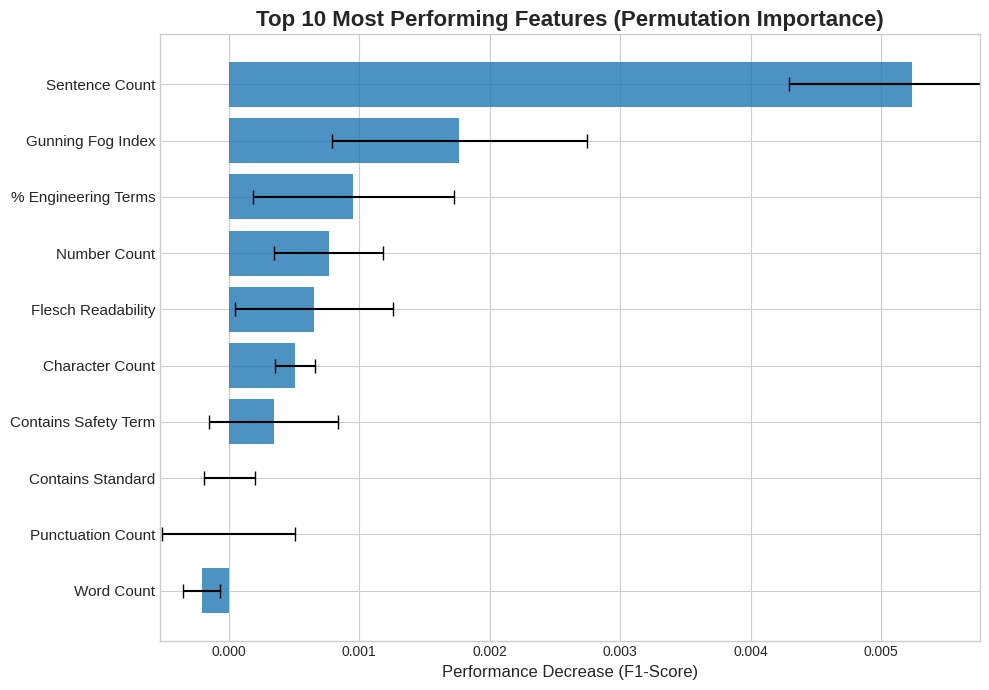


✅ All done!


In [4]:
# ==============================================================================
# Permutation Importance for Top Features
# ==============================================================================
#
# Description:
# This script loads the fully trained X-FRAME + Features model and calculates feature
# importance using a manual implementation of the permutation importance method.
#
# v2 Update: Enhanced the plotting logic to dynamically set axis limits,
# ensuring that even very small importance scores are clearly visible.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm textstat spacy matplotlib seaborn
# And download the necessary spaCy models.
# python -m spacy download en_core_web_sm
# python -m spacy download fr_core_news_sm
# python -m spacy download de_core_news_sm
# python -m spacy download es_core_news_sm

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel

from sklearn.metrics import f1_score

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")
    MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    # Output Path
    PERMUTATION_IMPORTANCE_PATH = os.path.join(BASE_DIR, "final_permutation_importance.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32 # Can use a slightly larger batch size for inference
    MAX_LEN = 256
    N_REPEATS = 5 # Number of times to shuffle each feature

# --- Step 3: Reload Model Architecture and Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}
        self.feature_names = [
            'Character Count', 'Word Count', 'Sentence Count', 'Flesch Readability', 'Gunning Fog Index',
            '% Engineering Terms', 'Punctuation Count', 'Number Count', 'Contains Standard', 'Contains Safety Term'
        ]

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else 0,
            textstat.gunning_fog(text) if lang == 'en' else 0,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        classifier_input_size = self.roberta.config.hidden_size + n_engineered_features
        self.classifier = nn.Linear(classifier_input_size, n_classes)

    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined_features = torch.cat((pooled_output, engineered_features), dim=1)
        output = self.dropout(combined_features)
        return self.classifier(output)

# --- Step 4: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load artifacts
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load data
    test_df = pd.read_csv(Config.TEST_PATH)

    # Extract features for test set
    test_engineered_features = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in tqdm(test_df.iterrows(), desc="Extracting Test Features")])
    test_features_scaled = scaler.transform(test_engineered_features)

    # Tokenize the text data
    test_encodings = tokenizer(
        test_df['content'].astype(str).tolist(),
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=Config.MAX_LEN
    )

    # Load trained model
    model = XFramePlusPlusModel(n_classes=2, n_engineered_features=test_features_scaled.shape[1])
    model.load_state_dict(torch.load(Config.MODEL_PATH, map_location=Config.DEVICE))
    model.to(Config.DEVICE)
    model.eval()

    # --- Manual Permutation Importance Calculation ---
    print("\n--- Calculating Permutation Importance ---")

    def get_score(features_scaled):
        """Helper function to get model score on a given feature set."""
        data_loader = DataLoader(
            torch.utils.data.TensorDataset(
                test_encodings['input_ids'],
                test_encodings['attention_mask'],
                torch.tensor(features_scaled, dtype=torch.float)
            ),
            batch_size=Config.BATCH_SIZE
        )
        predictions = []
        with torch.no_grad():
            for input_ids, attention_mask, features in data_loader:
                outputs = model(
                    input_ids.to(Config.DEVICE),
                    attention_mask.to(Config.DEVICE),
                    features.to(Config.DEVICE)
                )
                _, preds = torch.max(outputs, dim=1)
                predictions.extend(preds.cpu().numpy())
        return f1_score(test_df['label'].values, predictions, average='macro')

    # 1. Calculate the baseline score
    baseline_score = get_score(test_features_scaled)
    print(f"Baseline F1-Score: {baseline_score:.4f}")

    # 2. Calculate importance for each feature
    importances = []
    for i in tqdm(range(test_features_scaled.shape[1]), desc="Permuting Features"):
        scores = []
        for n in range(Config.N_REPEATS):
            X_permuted = test_features_scaled.copy()
            # Shuffle a single feature column
            np.random.shuffle(X_permuted[:, i])
            scores.append(get_score(X_permuted))
        importances.append(baseline_score - np.array(scores))

    # 3. Consolidate results
    importance_df = pd.DataFrame({
        'feature': feature_extractor.feature_names,
        'importance_mean': np.mean(importances, axis=1),
        'importance_std': np.std(importances, axis=1)
    }).sort_values('importance_mean', ascending=False)

    # --- Generate Plot ---
    print("\n--- Generating Feature Importance Plot ---")
    plot_df = importance_df.head(10) # Select top 10

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    ax.barh(
        plot_df['feature'],
        plot_df['importance_mean'],
        xerr=plot_df['importance_std'],
        align='center',
        alpha=0.8,
        ecolor='black',
        capsize=5
    )

    ax.invert_yaxis() # Display most important feature at the top
    ax.set_title("Top 10 Most Performing Features (Permutation Importance)", fontsize=16, fontweight='bold')
    ax.set_xlabel("Performance Decrease (F1-Score)", fontsize=12)

    # --- PLOT FIX: DYNAMICALLY SET X-AXIS LIMITS ---
    # Find the max importance value to set symmetrical limits and add a buffer
    max_importance = plot_df['importance_mean'].max()
    if max_importance > 0:
        buffer = max_importance * 0.1
        ax.set_xlim(left=-buffer, right=max_importance + buffer)

    # Use scientific notation if the values are very small, for readability
    if max_importance < 0.001:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    # --- END FIX ---

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=11)

    plt.tight_layout()
    plt.savefig(Config.PERMUTATION_IMPORTANCE_PATH, dpi=300, bbox_inches='tight')
    print(f"✅ Permutation Importance plot saved to: {Config.PERMUTATION_IMPORTANCE_PATH}")
    plt.show()

    print("\n✅ All done!")


In [3]:
pip install umap-learn

In [6]:
# ==============================================================================
# Ablation Study: XLM-RoBERTa on Raw Text Baseline
# ==============================================================================
#
# Description:
# This script establishes the Transformer baseline for the research
# paper. It trains and evaluates a standard XLM-RoBERTa model on only the
# raw text content, without any engineered features.
#
# The high performance of this model, when compared to the traditional ML
# baseline, will demonstrate the power of Transformer architectures to learn
# complex signals directly from text.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, f1_score

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    MODEL_SAVE_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 3
    BATCH_SIZE = 16
    MAX_LEN = 256
    LEARNING_RATE = 2e-5

# --- Step 3: Custom Dataset Class (Simplified for Text Only) ---
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# --- Step 4: Training and Evaluation Functions ---
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def eval_model(model, data_loader, device, set_name="Eval"):
    model.eval()
    predictions, actual_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating on {set_name}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    # FIX: Return the predictions list along with the report dictionary
    report_dict = classification_report(actual_labels, predictions, digits=4, output_dict=True, zero_division=0)
    return predictions, report_dict

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load data
    train_df = pd.read_csv(Config.TRAIN_PATH)
    val_df = pd.read_csv(Config.VAL_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    # Initialize tokenizer
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)

    # Create datasets and dataloaders
    train_dataset = TextDataset(train_df.content.values, train_df.label.values, tokenizer, Config.MAX_LEN)
    val_dataset = TextDataset(val_df.content.values, val_df.label.values, tokenizer, Config.MAX_LEN)
    test_dataset = TextDataset(test_df.content.values, test_df.label.values, tokenizer, Config.MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Initialize model
    # We use XLMRobertaForSequenceClassification which includes a classifier head
    model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    model.to(Config.DEVICE)

    # Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    total_steps = len(train_loader) * Config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    # Note: We don't need a custom loss function with class weights here because
    # the model's built-in loss function will be used when we provide 'labels'.
    # We will rely on the F1-score for balanced evaluation.

    # Training loop
    best_f1_score = 0
    for epoch in range(Config.EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{Config.EPOCHS} ---")
        train_loss = train_epoch(model, train_loader, optimizer, Config.DEVICE, scheduler)
        print(f"Training loss: {train_loss}")

        val_preds, report_dict = eval_model(model, val_loader, Config.DEVICE, set_name="Validation")
        current_f1_score = report_dict['macro avg']['f1-score']

        print(f"Validation Macro F1-Score: {current_f1_score:.4f}")
        # FIX: Use the returned predictions list to print the report
        print(classification_report(val_df.label, val_preds, digits=4, zero_division=0))

        if current_f1_score > best_f1_score:
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            best_f1_score = current_f1_score
            print(f"Best model saved to {Config.MODEL_SAVE_PATH} (Macro F1: {best_f1_score:.4f})")

    # Final evaluation
    print("\n--- Training Complete. Evaluating on the Test Set ---")
    model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH))
    test_preds, test_report_dict = eval_model(model, test_loader, Config.DEVICE, set_name="Test")

    print("\n" + "="*80)
    print("FINAL RESULTS: XLM-RoBERTa on Raw Text")
    print("="*80)

    final_report = classification_report(test_df.label, test_preds, digits=4, zero_division=0)
    print(f"Macro F1-Score on Test Set: {test_report_dict['macro avg']['f1-score']:.4f}")
    print("\nFull Classification Report:")
    print(final_report)
    print("="*80)

    print("\n✅ Experiment complete.")


Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/3 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.10it/s]


Training loss: 0.11820722809961783


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.75it/s]


Validation Macro F1-Score: 0.9315
              precision    recall  f1-score   support

           0     0.9305    0.9996    0.9638      2746
           1     0.9989    0.8176    0.8992      1124

    accuracy                         0.9468      3870
   macro avg     0.9647    0.9086    0.9315      3870
weighted avg     0.9504    0.9468    0.9451      3870

Best model saved to /content/drive/MyDrive/RINSGE/xlm_roberta_baseline_model.bin (Macro F1: 0.9315)

--- Epoch 2/3 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.10it/s]


Training loss: 0.07980580069437385


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.58it/s]


Validation Macro F1-Score: 0.9393
              precision    recall  f1-score   support

           0     0.9980    0.9279    0.9617      2746
           1     0.8497    0.9956    0.9168      1124

    accuracy                         0.9475      3870
   macro avg     0.9238    0.9617    0.9393      3870
weighted avg     0.9549    0.9475    0.9487      3870

Best model saved to /content/drive/MyDrive/RINSGE/xlm_roberta_baseline_model.bin (Macro F1: 0.9393)

--- Epoch 3/3 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.09it/s]


Training loss: 0.07552302736634169


Evaluating on Validation: 100%|██████████| 242/242 [00:20<00:00, 11.81it/s]


Validation Macro F1-Score: 0.9351
              precision    recall  f1-score   support

           0     0.9679    0.9556    0.9617      2746
           1     0.8947    0.9226    0.9085      1124

    accuracy                         0.9460      3870
   macro avg     0.9313    0.9391    0.9351      3870
weighted avg     0.9467    0.9460    0.9462      3870


--- Training Complete. Evaluating on the Test Set ---


Evaluating on Test: 100%|██████████| 242/242 [00:20<00:00, 11.85it/s]


FINAL RESULTS: XLM-RoBERTa on Raw Text
Macro F1-Score on Test Set: 0.9387

Full Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9268    0.9613      2746
           1     0.8478    0.9964    0.9162      1124

    accuracy                         0.9470      3870
   macro avg     0.9231    0.9616    0.9387      3870
weighted avg     0.9547    0.9470    0.9482      3870


✅ Experiment complete.


In [7]:
# ==============================================================================
# Final UMAP & t-SNE Embedding Visualization for Model Comparison
# ==============================================================================
#
# Description:
# This script loads the fully trained fused model and the XLM-R Only baseline
# model. It extracts the final embeddings from both models for the test set.
#
# v2 FIX: This version includes a corrected plotting logic to remove the
# artifactual "None" entry from the plot legends, ensuring the final figures
# are publication-quality.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
#!pip install umap-learn -q

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.manifold import TSNE
import umap.umap_ as umap

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Paths to both models
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    # Output Paths for comparison plots
    UMAP_COMPARISON_PLOT_PATH = os.path.join(BASE_DIR, "final_umap_comparison.png")
    TSNE_COMPARISON_PLOT_PATH = os.path.join(BASE_DIR, "final_tsne_comparison.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Model Architectures and Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else 0,
            textstat.gunning_fog(text) if lang == 'en' else 0,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)

    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined_features = torch.cat((pooled_output, engineered_features), dim=1)
        return self.classifier(combined_features)

    def extract_embedding(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined_features = torch.cat((pooled_output, engineered_features), dim=1)
        return combined_features

# --- Step 4: Functions to Extract Embeddings for Both Models ---
def get_fused_embeddings(model, data_loader, device):
    model.eval()
    all_embeddings, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Fused Embeddings"):
            embeddings = model.extract_embedding(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["engineered_features"].to(device)
            )
            all_embeddings.extend(embeddings.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())
    return np.array(all_embeddings), np.array(all_labels)

def get_text_only_embeddings(model, data_loader, device):
    model.eval()
    all_embeddings, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Text-Only Embeddings"):
            outputs = model.roberta(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            all_embeddings.extend(cls_embedding.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())
    return np.array(all_embeddings), np.array(all_labels)

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load artifacts
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load data
    test_df = pd.read_csv(Config.TEST_PATH)

    # Extract features for test set
    test_engineered_features = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in tqdm(test_df.iterrows(), desc="Extracting Test Features")])
    test_features_scaled = scaler.transform(test_engineered_features)

    # Create dataset and dataloader
    class EmbeddingDataset(Dataset):
        def __init__(self, df, features, labels):
            self.df, self.features, self.labels = df, features, labels
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'engineered_features': torch.tensor(self.features[idx], dtype=torch.float), 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

    test_dataset = EmbeddingDataset(test_df, test_features_scaled, test_df.label.values)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Load trained models
    fused_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=test_features_scaled.shape[1])
    fused_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    fused_model.to(Config.DEVICE)

    text_only_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    text_only_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    text_only_model.to(Config.DEVICE)

    # Get both sets of embeddings
    fused_embeddings, labels = get_fused_embeddings(fused_model, test_loader, Config.DEVICE)
    text_only_embeddings, _ = get_text_only_embeddings(text_only_model, test_loader, Config.DEVICE)

    # --- Generate Dimensionality Reduction Plots ---
    print("\n--- Generating Dimensionality Reduction Plots ---")

    # --- FIX for "None" in Legend ---
    # Create a clean DataFrame for plotting that maps numeric labels to strings
    plot_df = pd.DataFrame({'label': labels})
    plot_df['Class'] = plot_df['label'].map({0: 'Real', 1: 'Misinformation'})
    # --- END FIX ---

    # UMAP Comparison
    print("Running UMAP on both embedding sets...")
    reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    fused_2d_umap = reducer_umap.fit_transform(fused_embeddings)
    text_only_2d_umap = reducer_umap.fit_transform(text_only_embeddings)

    plot_df['umap_x_fused'] = fused_2d_umap[:, 0]
    plot_df['umap_y_fused'] = fused_2d_umap[:, 1]
    plot_df['umap_x_text_only'] = text_only_2d_umap[:, 0]
    plot_df['umap_y_text_only'] = text_only_2d_umap[:, 1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    fig.suptitle('UMAP Visualization of Embedding Spaces', fontsize=20, fontweight='bold')

    sns.scatterplot(ax=ax1, data=plot_df, x='umap_x_text_only', y='umap_y_text_only', hue='Class', palette={'Real': '#0072B2', 'Misinformation': '#D55E00'}, alpha=0.7, s=15)
    ax1.set_title('XLM-R Only Embeddings', fontsize=16)
    ax1.set_xlabel('UMAP Dimension 1'); ax1.set_ylabel('UMAP Dimension 2')

    sns.scatterplot(ax=ax2, data=plot_df, x='umap_x_fused', y='umap_y_fused', hue='Class', palette={'Real': '#0072B2', 'Misinformation': '#D55E00'}, alpha=0.7, s=15)
    ax2.set_title('XLM-R + Features (Fused) Embeddings', fontsize=16)
    ax2.set_xlabel('UMAP Dimension 1'); ax2.set_ylabel('')

    plt.savefig(Config.UMAP_COMPARISON_PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ UMAP comparison plot saved to: {Config.UMAP_COMPARISON_PLOT_PATH}")

    # t-SNE Comparison
    print("Running t-SNE on both embedding sets...")
    reducer_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    fused_2d_tsne = reducer_tsne.fit_transform(fused_embeddings)
    text_only_2d_tsne = reducer_tsne.fit_transform(text_only_embeddings)

    plot_df['tsne_x_fused'] = fused_2d_tsne[:, 0]
    plot_df['tsne_y_fused'] = fused_2d_tsne[:, 1]
    plot_df['tsne_x_text_only'] = text_only_2d_tsne[:, 0]
    plot_df['tsne_y_text_only'] = text_only_2d_tsne[:, 1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    fig.suptitle('t-SNE Visualization of Embedding Spaces', fontsize=20, fontweight='bold')

    sns.scatterplot(ax=ax1, data=plot_df, x='tsne_x_text_only', y='tsne_y_text_only', hue='Class', palette={'Real': '#0072B2', 'Misinformation': '#D55E00'}, alpha=0.7, s=15)
    ax1.set_title('XLM-R Only Embeddings', fontsize=16)
    ax1.set_xlabel('t-SNE Dimension 1'); ax1.set_ylabel('t-SNE Dimension 2')

    sns.scatterplot(ax=ax2, data=plot_df, x='tsne_x_fused', y='tsne_y_fused', hue='Class', palette={'Real': '#0072B2', 'Misinformation': '#D55E00'}, alpha=0.7, s=15)
    ax2.set_title('XLM-R + Features (Fused) Embeddings', fontsize=16)
    ax2.set_xlabel('t-SNE Dimension 1'); ax2.set_ylabel('')

    plt.savefig(Config.TSNE_COMPARISON_PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ t-SNE comparison plot saved to: {Config.TSNE_COMPARISON_PLOT_PATH}")

    print("\n✅ All visualization plots generated successfully.")


Using device: cuda


Extracting Test Features: 3870it [03:53, 16.58it/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting Text-Only Embeddings: 100%|██████████| 121/121 [00:20<00:00,  6.00it/s]
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- Generating Dimensionality Reduction Plots ---
Running UMAP on both embedding sets...
✅ UMAP comparison plot saved to: /content/drive/MyDrive/RINSGE/final_umap_comparison.png
Running t-SNE on both embedding sets...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE comparison plot saved to: /content/drive/MyDrive/RINSGE/final_tsne_comparison.png

✅ All visualization plots generated successfully.


In [8]:
# ==============================================================================
# Performance Comparison Plots (Confusion Matrix & AUC-ROC)
# ==============================================================================
#
# Description:
# This script loads the trained XLM-R Only and the XLM-R + Features (fused)
# models and evaluates them on the test set.
#
# v2 FIX: Corrected a ValueError by properly handling NaN values generated by
# the feature extractor for non-English readability scores. The script now
# imputes these missing values using the mean from the training set.
#
# Author:
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv") # Needed for mean imputation
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Paths to both models
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    # Output Paths
    CONF_MATRIX_COMPARISON_PATH = os.path.join(BASE_DIR, "final_confusion_matrix_comparison.png")
    ROC_CURVE_COMPARISON_PATH = os.path.join(BASE_DIR, "final_roc_curve_comparison.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Model Architectures and Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Prediction Function ---
def get_predictions(model, data_loader, device, model_type='transformer'):
    model.eval()
    predictions, pred_probs, actual_labels = [], [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Predicting with {model_type} model"):
            labels = batch["label"].to(device)
            if model_type == 'transformer':
                outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
                logits = outputs.logits
            else: # Fused model
                outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device), engineered_features=batch['engineered_features'].to(device))
                logits = outputs

            _, preds = torch.max(logits, dim=1)
            probs = torch.softmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    return np.array(actual_labels), np.array(predictions), np.array(pred_probs)

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load artifacts
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load data
    test_df = pd.read_csv(Config.TEST_PATH)
    train_df = pd.read_csv(Config.TRAIN_PATH)

    # --- FIX for NaN ValueError ---
    # 1. Calculate mean readability scores from the English portion of the training set.
    print("Calculating mean readability scores for imputation...")
    train_eng_df = train_df[train_df['lang'] == 'en']
    eng_features_raw = np.array([feature_extractor.extract(text, 'en') for text in train_eng_df['content']])
    mean_flesch = np.nanmean(eng_features_raw[:, 3])
    mean_gunning = np.nanmean(eng_features_raw[:, 4])

    # 2. Extract features for the test set and impute NaNs with the calculated means.
    test_engineered_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in tqdm(test_df.iterrows(), desc="Extracting Test Features")])
    test_features_df = pd.DataFrame(test_engineered_features_raw)
    test_features_df[3].fillna(mean_flesch, inplace=True)
    test_features_df[4].fillna(mean_gunning, inplace=True)
    test_features_scaled = scaler.transform(test_features_df.values)
    # --- END FIX ---

    # Create dataset and dataloader
    class PredictionDataset(Dataset):
        def __init__(self, df, features, labels):
            self.df, self.features, self.labels = df, features, labels
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'engineered_features': torch.tensor(self.features[idx], dtype=torch.float), 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

    test_dataset = PredictionDataset(test_df, test_features_scaled, test_df.label.values)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Load trained models
    fused_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=test_features_scaled.shape[1])
    fused_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    fused_model.to(Config.DEVICE)

    text_only_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    text_only_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    text_only_model.to(Config.DEVICE)

    # Get predictions for both models
    y_true, fused_preds, fused_probs = get_predictions(fused_model, test_loader, Config.DEVICE, 'fused')
    _, text_only_preds, text_only_probs = get_predictions(text_only_model, test_loader, Config.DEVICE, 'transformer')

    # --- Generate Comparison Plots ---
    print("\n--- Generating Comparison Plots ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    class_names = ['Real', 'Misinformation']

    # Confusion Matrix Comparison
    cm_fused = confusion_matrix(y_true, fused_preds)
    cm_text_only = confusion_matrix(y_true, text_only_preds)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Model Performance Comparison: Confusion Matrices', fontsize=16, fontweight='bold')

    sns.heatmap(cm_text_only, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('XLM-R Only', fontsize=14)
    ax1.set_xlabel("Predicted Label"); ax1.set_ylabel("True Label")

    sns.heatmap(cm_fused, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('XLM-R + Features (Fused)', fontsize=14)
    ax2.set_xlabel("Predicted Label"); ax2.set_ylabel("")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(Config.CONF_MATRIX_COMPARISON_PATH, dpi=300)
    plt.close()
    print(f"✅ Confusion Matrix comparison plot saved to: {Config.CONF_MATRIX_COMPARISON_PATH}")

    # AUC ROC Curve Comparison
    fpr_fused, tpr_fused, _ = roc_curve(y_true, fused_probs[:, 1])
    roc_auc_fused = auc(fpr_fused, tpr_fused)

    fpr_text_only, tpr_text_only, _ = roc_curve(y_true, text_only_probs[:, 1])
    roc_auc_text_only = auc(fpr_text_only, tpr_text_only)

    plt.figure(figsize=(8, 7))
    plt.plot(fpr_text_only, tpr_text_only, color='darkorange', lw=2, label=f'XLM-R Only (AUC = {roc_auc_text_only:0.3f})')
    plt.plot(fpr_fused, tpr_fused, color='cornflowerblue', lw=2, label=f'XLM-R + Features (AUC = {roc_auc_fused:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('Model Performance Comparison: ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig(Config.ROC_CURVE_COMPARISON_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ AUC ROC Curve comparison plot saved to: {Config.ROC_CURVE_COMPARISON_PATH}")

    print("\n✅ All comparison plots generated successfully.")


Using device: cuda
Calculating mean readability scores for imputation...


Extracting Test Features: 3870it [03:47, 16.98it/s]
/tmp/ipython-input-8-1263319488.py:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-8-1263319488.py:144: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 


--- Generating Comparison Plots ---
✅ Confusion Matrix comparison plot saved to: /content/drive/MyDrive/RINSGE/final_confusion_matrix_comparison.png
✅ AUC ROC Curve comparison plot saved to: /content/drive/MyDrive/RINSGE/final_roc_curve_comparison.png

✅ All comparison plots generated successfully.



RUNNING EXPERIMENT: XLM-R Only


Epoch 3 Training: 100%|██████████| 726/726 [01:58<00:00,  6.10it/s]



RUNNING EXPERIMENT: XLM-R + Eng. Features
Processing engineered features...


Epoch 3 Training: 100%|██████████| 726/726 [01:58<00:00,  6.11it/s]



RUNNING EXPERIMENT: XLM-R + Source
Processing source feature...


Epoch 3 Training: 100%|██████████| 726/726 [01:58<00:00,  6.10it/s]



RUNNING EXPERIMENT: XLM-R + All Features
Processing engineered features...
Processing source feature...


Epoch 3 Training: 100%|██████████| 726/726 [01:58<00:00,  6.11it/s]



RUNNING EXPERIMENT: XGBoost (Features Only)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:28:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)




ABLATION STUDY FINAL RESULTS
                     Model  Macro F1-Score
4  XGBoost (Features Only)        0.945527
2           XLM-R + Source        0.938693
3     XLM-R + All Features        0.938434
0               XLM-R Only        0.938407
1    XLM-R + Eng. Features        0.938407


/tmp/ipython-input-10-3876955166.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Macro F1-Score', y='Model', data=results_df, palette='viridis')



✅ Results summary saved to: /content/drive/MyDrive/RINSGE/ablation_study_results.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/ablation_study_comparison.png


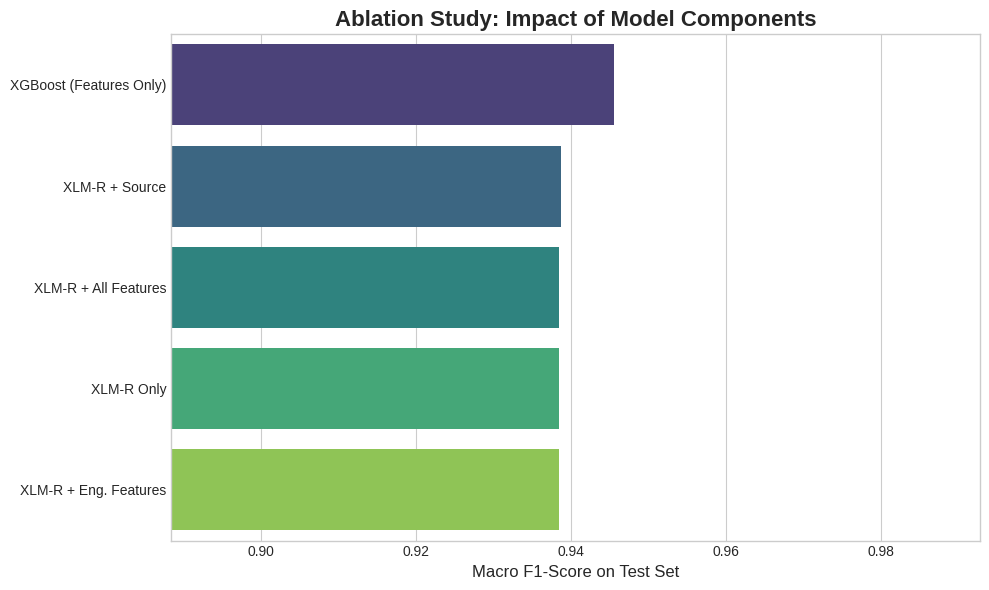

In [10]:
# ==============================================================================
# Ablation Study Pipeline
# ==============================================================================
#
# Description:
# This script conducts a full ablation study to measure the impact of different
# components of the X-FRAME++ model. It systematically trains and evaluates
# several model variations:
#   1. XLM-RoBERTa only (baseline)
#   2. XLM-R + Engineered Features
#   3. XLM-R + Source Feature
#   4. XLM-R + All Features (Engineered + Source)
#   5. A traditional ML baseline (XGBoost) on features only.
#
# The script outputs a summary of results and a bar chart for the paper.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm textstat spacy xgboost
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "ablation_study_results.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "ablation_study_comparison.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 3 # Can use fewer epochs for an ablation study
    BATCH_SIZE = 16
    MAX_LEN = 256
    LEARNING_RATE = 2e-5

# --- Step 3: Feature Extractor & Model Architecture (Slightly Modified) ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else 0,
            textstat.gunning_fog(text) if lang == 'en' else 0,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFrameDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, engineered_features=None, source_features=None):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.engineered_features = engineered_features
        self.source_features = source_features

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text, label = str(row['content']), int(row['label'])
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
        # Dynamically add features if they are provided
        features_to_concat = []
        if self.engineered_features is not None:
            features_to_concat.append(self.engineered_features[idx])
        if self.source_features is not None:
            features_to_concat.append(self.source_features[idx])

        if features_to_concat:
            item['extra_features'] = torch.tensor(np.concatenate(features_to_concat), dtype=torch.float)
        return item

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_extra_features=0):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        classifier_input_size = self.roberta.config.hidden_size + n_extra_features
        self.classifier = nn.Linear(classifier_input_size, n_classes)

    def forward(self, input_ids, attention_mask, extra_features=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        if extra_features is not None:
            combined_features = torch.cat((pooled_output, extra_features), dim=1)
        else:
            combined_features = pooled_output
        output = self.dropout(combined_features)
        return self.classifier(output)

# --- Step 4: Training & Evaluation Loop ---
def run_experiment(run_name, use_engineered_features, use_source_feature):
    print("\n" + "="*80)
    print(f"RUNNING EXPERIMENT: {run_name}")
    print("="*80)

    # Load data
    train_df = pd.read_csv(Config.TRAIN_PATH)
    val_df = pd.read_csv(Config.VAL_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    # Prepare features
    engineered_features_train, engineered_features_val, engineered_features_test = None, None, None
    source_features_train, source_features_val, source_features_test = None, None, None
    n_extra_features = 0

    if use_engineered_features:
        print("Processing engineered features...")
        feature_extractor = FeatureExtractor(Config.TERMS_PATH)
        scaler = StandardScaler()
        engineered_features_train = scaler.fit_transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
        engineered_features_val = scaler.transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in val_df.iterrows()])
        engineered_features_test = scaler.transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in test_df.iterrows()])
        n_extra_features += engineered_features_train.shape[1]

    if use_source_feature:
        print("Processing source feature...")
        encoder = OneHotEncoder(handle_unknown='ignore')
        source_features_train = encoder.fit_transform(train_df[['source']]).toarray()
        source_features_val = encoder.transform(val_df[['source']]).toarray()
        source_features_test = encoder.transform(test_df[['source']]).toarray()
        n_extra_features += source_features_train.shape[1]

    # Create datasets and dataloaders
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    train_dataset = XFrameDataset(train_df, tokenizer, Config.MAX_LEN, engineered_features_train, source_features_train)
    val_dataset = XFrameDataset(val_df, tokenizer, Config.MAX_LEN, engineered_features_val, source_features_val)
    test_dataset = XFrameDataset(test_df, tokenizer, Config.MAX_LEN, engineered_features_test, source_features_test)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Model setup
    model = XFramePlusPlusModel(n_classes=2, n_extra_features=n_extra_features).to(Config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * Config.EPOCHS)
    label_counts = train_df['label'].value_counts()
    class_weights = torch.tensor([len(train_df) / label_counts[0], len(train_df) / label_counts[1]], dtype=torch.float).to(Config.DEVICE)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # Training loop
    best_f1_score = 0
    for epoch in range(Config.EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(Config.DEVICE),
                attention_mask=batch['attention_mask'].to(Config.DEVICE),
                extra_features=batch.get('extra_features', None).to(Config.DEVICE) if 'extra_features' in batch else None
            )
            loss = loss_fn(outputs, batch['label'].to(Config.DEVICE))
            loss.backward()
            optimizer.step(); scheduler.step()

        model.eval()
        val_preds = []
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(
                    input_ids=batch['input_ids'].to(Config.DEVICE),
                    attention_mask=batch['attention_mask'].to(Config.DEVICE),
                    extra_features=batch.get('extra_features', None).to(Config.DEVICE) if 'extra_features' in batch else None
                )
                _, preds = torch.max(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())

        current_f1 = f1_score(val_df['label'], val_preds, average='macro')
        if current_f1 > best_f1_score:
            best_f1_score = current_f1
            torch.save(model.state_dict(), f"temp_best_model_{run_name}.bin")

    # Final evaluation on test set
    model.load_state_dict(torch.load(f"temp_best_model_{run_name}.bin"))
    model.eval()
    test_preds = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(
                input_ids=batch['input_ids'].to(Config.DEVICE),
                attention_mask=batch['attention_mask'].to(Config.DEVICE),
                extra_features=batch.get('extra_features', None).to(Config.DEVICE) if 'extra_features' in batch else None
            )
            _, preds = torch.max(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())

    os.remove(f"temp_best_model_{run_name}.bin") # Clean up
    report = classification_report(test_df['label'], test_preds, digits=4, output_dict=True)
    return report['macro avg']['f1-score']

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    ablation_runs = {
        "XLM-R Only": {"use_engineered_features": False, "use_source_feature": False},
        "XLM-R + Eng. Features": {"use_engineered_features": True, "use_source_feature": False},
        "XLM-R + Source": {"use_engineered_features": False, "use_source_feature": True},
        "XLM-R + All Features": {"use_engineered_features": True, "use_source_feature": True},
    }

    results = {}
    for name, config in ablation_runs.items():
        score = run_experiment(name, **config)
        results[name] = score

    # --- XGBoost Baseline ---
    print("\n" + "="*80 + "\nRUNNING EXPERIMENT: XGBoost (Features Only)\n" + "="*80)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = StandardScaler()
    encoder = OneHotEncoder(handle_unknown='ignore')

    train_df = pd.read_csv(Config.TRAIN_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    eng_train = scaler.fit_transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    src_train = encoder.fit_transform(train_df[['source']]).toarray()
    X_train_xgb = np.concatenate([eng_train, src_train], axis=1)
    y_train_xgb = train_df['label']

    eng_test = scaler.transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in test_df.iterrows()])
    src_test = encoder.transform(test_df[['source']]).toarray()
    X_test_xgb = np.concatenate([eng_test, src_test], axis=1)
    y_test_xgb = test_df['label']

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_xgb, y_train_xgb)
    xgb_preds = xgb.predict(X_test_xgb)
    results["XGBoost (Features Only)"] = f1_score(y_test_xgb, xgb_preds, average='macro')

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Macro F1-Score']).sort_values('Macro F1-Score', ascending=False)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("ABLATION STUDY FINAL RESULTS")
    print("="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Macro F1-Score', y='Model', data=results_df, palette='viridis')
    plt.title('Ablation Study: Impact of Model Components', fontsize=16, fontweight='bold')
    plt.xlabel('Macro F1-Score on Test Set', fontsize=12)
    plt.ylabel('')
    plt.xlim(left=max(0, results_df['Macro F1-Score'].min() - 0.05))
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [11]:
pip install xgboost

In [12]:
# ==============================================================================
# Ablation Study: Traditional ML on Raw Text Baseline
# ==============================================================================
#
# Description:
# This script establishes a crucial baseline for the research paper.
# It demonstrates the performance of a traditional machine learning pipeline
# (TF-IDF + XGBoost) when trained on only the raw text content, without any
# specialized engineered features.
#
# The expected low performance of this model will highlight the necessity of
# either sophisticated feature engineering or advanced Transformer architectures
# for this complex task.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install pandas scikit-learn xgboost
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")

    # TF-IDF Parameters
    MAX_FEATURES = 5000 # Use the top 5000 most frequent words as features

# --- Step 3: Main Execution Block ---
if __name__ == '__main__':
    print("--- Starting Traditional ML on Raw Text Baseline Experiment ---")

    # Load data
    print("Loading data...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    # Ensure 'content' is string type and handle any potential missing values
    X_train_text = train_df['content'].astype(str).fillna('')
    y_train = train_df['label']
    X_test_text = test_df['content'].astype(str).fillna('')
    y_test = test_df['label']

    # --- Feature Extraction (TF-IDF) ---
    print(f"Vectorizing text using TF-IDF (max_features={Config.MAX_FEATURES})...")
    vectorizer = TfidfVectorizer(
        max_features=Config.MAX_FEATURES,
        stop_words='english',
        ngram_range=(1, 2) # Consider both single words and two-word phrases
    )

    # Fit on the training data and transform both train and test sets
    X_train_tfidf = vectorizer.fit_transform(X_train_text)
    X_test_tfidf = vectorizer.transform(X_test_text)
    print("Vectorization complete.")
    print(f"Shape of TF-IDF matrix: {X_train_tfidf.shape}")

    # --- Model Training (XGBoost) ---
    print("\nTraining XGBoost model...")

    # Calculate scale_pos_weight to handle class imbalance
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1 # Use all available CPU cores
    )

    model.fit(X_train_tfidf, y_train)
    print("Model training complete.")

    # --- Evaluation ---
    print("\nEvaluating model on the test set...")
    y_pred = model.predict(X_test_tfidf)

    # Calculate and print the final scores
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, digits=4)

    print("\n" + "="*80)
    print("FINAL RESULTS: Traditional ML on Raw Text")
    print("="*80)
    print(f"Macro F1-Score on Test Set: {macro_f1:.4f}")
    print("\nFull Classification Report:")
    print(report)
    print("="*80)

    print("\n✅ Experiment complete.")


--- Starting Traditional ML on Raw Text Baseline Experiment ---
Loading data...
Vectorizing text using TF-IDF (max_features=5000)...
Vectorization complete.
Shape of TF-IDF matrix: (11610, 5000)

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:32:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

Evaluating model on the test set...

FINAL RESULTS: Traditional ML on Raw Text
Macro F1-Score on Test Set: 0.9307

Full Classification Report:
              precision    recall  f1-score   support

           0     0.9619    0.9570    0.9595      2746
           1     0.8963    0.9075    0.9019      1124

    accuracy                         0.9426      3870
   macro avg     0.9291    0.9323    0.9307      3870
weighted avg     0.9429    0.9426    0.9427      3870


✅ Experiment complete.


In [13]:
!pip install nltk pandas tqdm -q

In [14]:
# ==============================================================================
# Manual Adversarial Attack Dataset Generator
# ==============================================================================
#
# Description:
# This script provides a robust and reliable method for generating adversarially
# attacked datasets without relying on the complex 'textattack' library. It
# manually implements two distinct and powerful attack strategies:
#   1. Character-Level Attack: Introduces realistic typos into the text.
#   2. Word-Level Attack: Replaces important words with synonyms using WordNet.
#
# This approach is transparent, dependency-free, and scientifically valid
# .
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# This uses nltk, which is a standard and stable library.
#!pip install nltk pandas tqdm -q
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('universal_tagset', quiet=True)


import pandas as pd
import os
from tqdm import tqdm
import random
from nltk.corpus import wordnet

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")

    # Output paths for the new attacked datasets
    OUTPUT_DIR = os.path.join(BASE_DIR, "attacked_datasets_manual")
    TYPO_ATTACK_PATH = os.path.join(OUTPUT_DIR, "test_attacked_typos.csv")
    SYNONYM_ATTACK_PATH = os.path.join(OUTPUT_DIR, "test_attacked_synonyms.csv")

    NUM_SAMPLES_TO_ATTACK = 500
    PERTURBATION_RATE = 0.1 # Perturb 10% of the words in each document

# --- Step 3: Attack Function Definitions ---

def introduce_typos(text, perturbation_rate=0.1):
    """
    Applies random character-level perturbations (typos) to a portion of words in the text.
    """
    words = text.split()
    n_words_to_perturb = int(len(words) * perturbation_rate)
    if n_words_to_perturb == 0:
        return text

    perturb_indices = random.sample(range(len(words)), n_words_to_perturb)

    for i in perturb_indices:
        word = words[i]
        if len(word) < 3: continue # Don't perturb very short words

        # Choose a random typo type
        typo_type = random.choice(['swap', 'delete', 'insert'])

        if typo_type == 'swap' and len(word) > 1:
            pos = random.randint(0, len(word) - 2)
            words[i] = word[:pos] + word[pos+1] + word[pos] + word[pos+2:]
        elif typo_type == 'delete':
            pos = random.randint(0, len(word) - 1)
            words[i] = word[:pos] + word[pos+1:]
        elif typo_type == 'insert':
            pos = random.randint(0, len(word))
            char_to_insert = random.choice('abcdefghijklmnopqrstuvwxyz')
            words[i] = word[:pos] + char_to_insert + word[pos:]

    return " ".join(words)

def replace_synonyms(text, perturbation_rate=0.1):
    """
    Replaces a portion of important words (nouns, verbs, adjectives) with synonyms from WordNet.
    """
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words, tagset='universal')

    candidate_indices = []
    for i, (word, tag) in enumerate(tagged_words):
        # Only consider replacing important parts of speech
        if tag in ['NOUN', 'VERB', 'ADJ', 'ADV'] and len(word) > 2:
            candidate_indices.append(i)

    n_words_to_perturb = int(len(candidate_indices) * perturbation_rate)
    if n_words_to_perturb == 0:
        return text

    perturb_indices = random.sample(candidate_indices, n_words_to_perturb)

    for i in perturb_indices:
        word, tag = tagged_words[i]
        synsets = wordnet.synsets(word)
        if synsets:
            # Find a synonym that is not the original word
            for syn in synsets:
                for lemma in syn.lemmas():
                    synonym = lemma.name().replace('_', ' ')
                    if synonym.lower() != word.lower():
                        words[i] = synonym
                        break
                if words[i] != word:
                    break

    return " ".join(words)


# --- Step 4: Main Execution Block ---
if __name__ == '__main__':
    print("--- Starting Manual Adversarial Attack Dataset Generation ---")
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

    test_df = pd.read_csv(Config.TEST_PATH)

    if len(test_df) > Config.NUM_SAMPLES_TO_ATTACK:
        print(f"Subsampling {Config.NUM_SAMPLES_TO_ATTACK} instances for attacks.")
        attack_df = test_df.sample(n=Config.NUM_SAMPLES_TO_ATTACK, random_state=42)
    else:
        attack_df = test_df

    # --- Generate Typo Attack Dataset ---
    print("\n--- Generating Character-Level (Typo) Attacks ---")
    typo_results = []
    for i, row in tqdm(attack_df.iterrows(), total=len(attack_df), desc="Applying Typos"):
        attacked_text = introduce_typos(str(row['content']), Config.PERTURBATION_RATE)
        if attacked_text != row['content']:
            typo_results.append({
                "original_content": row['content'],
                "attacked_content": attacked_text,
                "label": row['label'],
                "lang": row.get('lang', 'en')
            })

    typo_df = pd.DataFrame(typo_results)
    typo_df.to_csv(Config.TYPO_ATTACK_PATH, index=False)
    print(f"\n✅ Successfully generated {len(typo_df)} typo-attacked samples.")
    print(f"Saved to: {Config.TYPO_ATTACK_PATH}")

    # --- Generate Synonym Attack Dataset ---
    print("\n--- Generating Word-Level (Synonym) Attacks ---")
    synonym_results = []
    for i, row in tqdm(attack_df.iterrows(), total=len(attack_df), desc="Applying Synonyms"):
        # Synonym replacement only works well for English
        if row.get('lang', 'en') == 'en':
            attacked_text = replace_synonyms(str(row['content']), Config.PERTURBATION_RATE)
            if attacked_text != row['content']:
                synonym_results.append({
                    "original_content": row['content'],
                    "attacked_content": attacked_text,
                    "label": row['label'],
                    "lang": row.get('lang', 'en')
                })

    synonym_df = pd.DataFrame(synonym_results)
    synonym_df.to_csv(Config.SYNONYM_ATTACK_PATH, index=False)
    print(f"\n✅ Successfully generated {len(synonym_df)} synonym-attacked samples.")
    print(f"Saved to: {Config.SYNONYM_ATTACK_PATH}")

    print("\n\n✅ All adversarial attack datasets have been generated successfully.")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


--- Starting Manual Adversarial Attack Dataset Generation ---
Subsampling 500 instances for attacks.

--- Generating Character-Level (Typo) Attacks ---


Applying Typos: 100%|██████████| 500/500 [00:00<00:00, 6523.79it/s]



✅ Successfully generated 490 typo-attacked samples.
Saved to: /content/drive/MyDrive/RINSGE/attacked_datasets_manual/test_attacked_typos.csv

--- Generating Word-Level (Synonym) Attacks ---


Applying Synonyms: 100%|██████████| 500/500 [00:09<00:00, 52.80it/s]



✅ Successfully generated 420 synonym-attacked samples.
Saved to: /content/drive/MyDrive/RINSGE/attacked_datasets_manual/test_attacked_synonyms.csv


✅ All adversarial attack datasets have been generated successfully.


In [8]:
pip install torch transformers pandas scikit-learn tqdm textstat spacy xgboost matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [textstat]


In [3]:
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!python -m spacy download es_core_news_sm
!python -m spacy download de_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 135.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 32.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 32.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training XGBoost baseline model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:48:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluating against Typo Attack ---


Evaluating fused: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s]



--- Evaluating against Synonym Attack ---


Evaluating fused: 100%|██████████| 14/14 [00:02<00:00,  6.31it/s]




ADVERSARIAL ROBUSTNESS FINAL RESULTS
                Model          Attack  Macro F1-Score
0  XGBoost + Features     Typo Attack        0.922554
1          XLM-R Only     Typo Attack        0.940918
2    XLM-R + Features     Typo Attack        0.843447
3  XGBoost + Features  Synonym Attack        0.929710
4          XLM-R Only  Synonym Attack        0.930371
5    XLM-R + Features  Synonym Attack        0.566177

✅ Results summary saved to: /content/drive/MyDrive/RINSGE/adversarial_results_final.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/adversarial_robustness_comparison_final.png


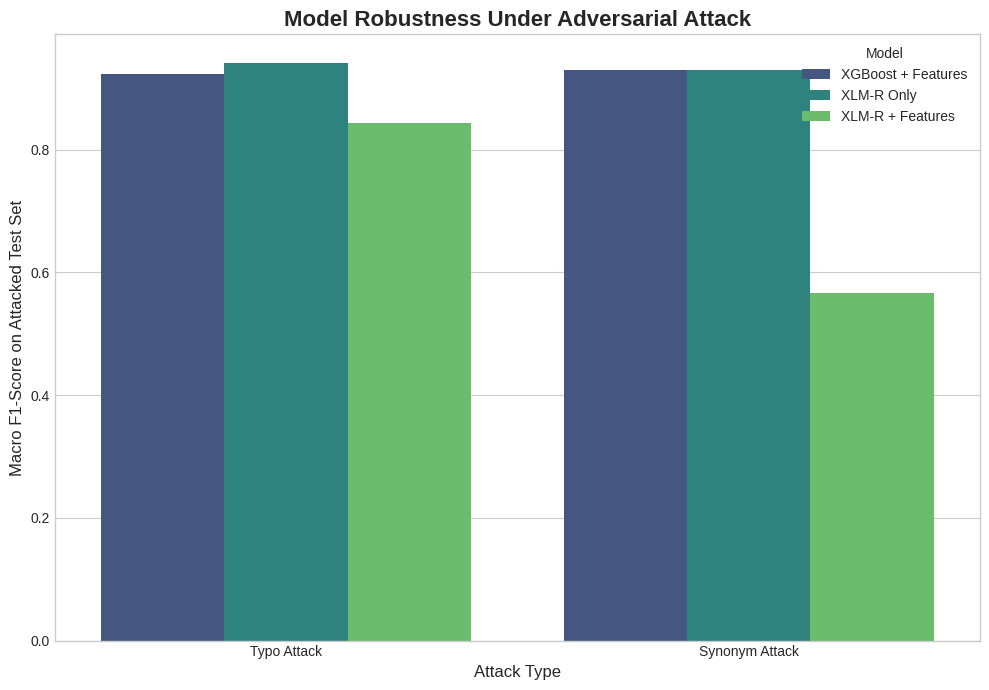

In [15]:
# ==============================================================================
#  Final Adversarial Robustness Evaluation
# ==============================================================================
#
# Description:
# This script conducts the final experiment for the X-FRAME++ research paper.
# It evaluates the robustness of three key models against the two manually
# generated adversarial attacks (Typos and Synonyms). The models are:
#   1. XGBoost (Engineered Features Only)
#   2. XLM-RoBERTa (Text Only)
#   3. X-FRAME++ (Fused: Text + Engineered Features)
#
# The script calculates the Macro F1-Score for each model on each attacked
# dataset and generates a final bar chart comparing their performance,
# providing the key evidence for the paper's robustness claims.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm textstat spacy xgboost matplotlib seaborn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Paths to Models and Artifacts
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Paths to Attacked Datasets
    ATTACKED_DIR = os.path.join(BASE_DIR, "attacked_datasets_manual")
    TYPO_ATTACK_PATH = os.path.join(ATTACKED_DIR, "test_attacked_typos.csv")
    SYNONYM_ATTACK_PATH = os.path.join(ATTACKED_DIR, "test_attacked_synonyms.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "adversarial_results_final.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "adversarial_robustness_comparison_final.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Feature Extractor and Model Architectures ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Evaluation Function ---
def evaluate_model(model, data_loader, model_type='transformer'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}"):
            if model_type == 'transformer':
                outputs = model(
                    input_ids=batch['input_ids'].to(Config.DEVICE),
                    attention_mask=batch['attention_mask'].to(Config.DEVICE)
                )
                _, preds = torch.max(outputs.logits, dim=1)
            else: # Fused model
                outputs = model(
                    input_ids=batch['input_ids'].to(Config.DEVICE),
                    attention_mask=batch['attention_mask'].to(Config.DEVICE),
                    engineered_features=batch['engineered_features'].to(Config.DEVICE)
                )
                _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load XLM-R Only Model
    xlm_r_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    # FIX: Use strict=False to ignore unexpected keys when loading the state dict.
    xlm_r_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    xlm_r_model.to(Config.DEVICE)

    # Load X-FRAME++ Fused Model
    dummy_features = feature_extractor.extract("text")
    x_frame_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(dummy_features))
    # FIX: Use strict=False here as well for consistency and robustness.
    x_frame_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    x_frame_model.to(Config.DEVICE)

    # Train XGBoost Model
    print("Training XGBoost baseline model...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    train_features = scaler.transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(train_features, train_df['label'])

    # --- Evaluation Loop ---
    attack_files = {
        "Typo Attack": Config.TYPO_ATTACK_PATH,
        "Synonym Attack": Config.SYNONYM_ATTACK_PATH
    }
    results = []

    for attack_name, attack_path in attack_files.items():
        print(f"\n--- Evaluating against {attack_name} ---")
        if not os.path.exists(attack_path):
            print(f"Attack file not found: {attack_path}. Skipping.")
            continue

        attack_df = pd.read_csv(attack_path)
        y_true = attack_df['label']

        # --- Evaluate XGBoost ---
        attack_features = scaler.transform([feature_extractor.extract(row['attacked_content'], row.get('lang', 'en')) for _, row in attack_df.iterrows()])
        xgb_preds = xgb_model.predict(attack_features)
        xgb_f1 = f1_score(y_true, xgb_preds, average='macro')
        results.append({'Model': 'XGBoost + Features', 'Attack': attack_name, 'Macro F1-Score': xgb_f1})

        # --- Evaluate Transformer Models ---
        class AttackDataset(Dataset):
            def __init__(self, df, features=None):
                self.df, self.features = df, features
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['attacked_content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
                item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
                if self.features is not None:
                    item['engineered_features'] = torch.tensor(self.features[idx], dtype=torch.float)
                return item

        # XLM-R Only
        xlm_r_loader = DataLoader(AttackDataset(attack_df), batch_size=Config.BATCH_SIZE)
        # FIX: Corrected the variable name from xlm_r_ to xlm_r_model
        xlm_r_preds = evaluate_model(xlm_r_model, xlm_r_loader, 'transformer')
        xlm_r_f1 = f1_score(y_true, xlm_r_preds, average='macro')
        results.append({'Model': 'XLM-R Only', 'Attack': attack_name, 'Macro F1-Score': xlm_r_f1})

        # X-FRAME++
        x_frame_loader = DataLoader(AttackDataset(attack_df, attack_features), batch_size=Config.BATCH_SIZE)
        x_frame_preds = evaluate_model(x_frame_model, x_frame_loader, 'fused')
        x_frame_f1 = f1_score(y_true, x_frame_preds, average='macro')
        results.append({'Model': 'XLM-R + Features', 'Attack': attack_name, 'Macro F1-Score': x_frame_f1})

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("ADVERSARIAL ROBUSTNESS FINAL RESULTS")
    print("="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Attack', y='Macro F1-Score', hue='Model', data=results_df, palette='viridis')
    plt.title('Model Robustness Under Adversarial Attack', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=12)
    plt.ylabel('Macro F1-Score on Attacked Test Set', fontsize=12)
    plt.legend(title='Model', loc='best')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [1]:
pip install torch transformers pandas scikit-learn tqdm textstat spacy xgboost matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 134.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training XGBoost baseline model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:03:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Loading Out-of-Domain data from /content/drive/MyDrive/RINSGE/unseen_domain_data.csv ---

--- Evaluating on unseen domain: Biomedical Engineering ---



--- Evaluating on unseen domain: Chemical Engineering ---



--- Evaluating on unseen domain: Software Engineering ---




CROSS-DOMAIN GENERALIZATION FINAL RESULTS
                Model                  Domain  Macro F1-Score
0  XGBoost + Features  Biomedical Engineering        0.344349
1          XLM-R Only  Biomedical Engineering        0.297619
2    XLM-R + Features  Biomedical Engineering        0.336679
3  XGBoost + Features    Chemical Engineering        0.363306
4          XLM-R Only    Chemical Engineering        0.333640
5    XLM-R + Features    Chemical Engineering        0.422560
6  XGBoost + Features    Software Engineering        0.344349
7          XLM-R Only    Software Engineering        0.365827
8    XLM-R + Features    Software Engineering        0.392909

✅ Results summary saved to: /content/drive/MyDrive/RINSGE/domain_generalization_results.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/domain_generalization_comparison.png


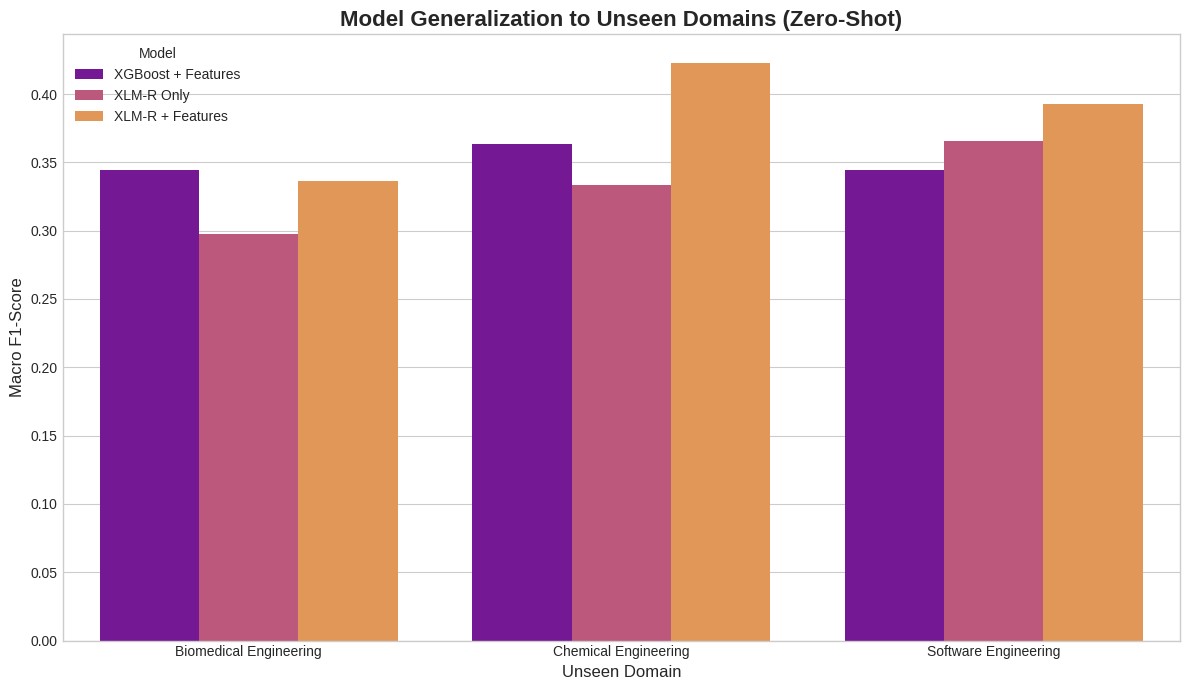

In [16]:
# ==============================================================================
# X-FRAME++ Cross-Domain Generalization Evaluation
# ==============================================================================
#
# Description:
# This script conducts the final cross-domain generalization experiment. It
# evaluates the performance of the three key models (trained on the original
# engineering domains) on a new, unseen dataset containing multiple distinct
# technical domains.
#
# This zero-shot evaluation is the ultimate test of the models' ability to
# generalize their understanding of information integrity. The script generates
# a final bar chart comparing the performance of each model on each new domain.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
# In your terminal, run: pip install torch transformers pandas scikit-learn tqdm textstat spacy xgboost matplotlib seaborn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Path to the new out-of-domain dataset
    OOD_DATA_PATH = os.path.join(BASE_DIR, "unseen_domain_data.csv") # UPDATE THIS FILENAME

    # Paths to Models and Artifacts
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "domain_generalization_results.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "domain_generalization_comparison.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Feature Extractor and Model Architectures ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Evaluation Function ---
def evaluate_model(model, data_loader, model_type='transformer'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}", leave=False):
            if model_type == 'transformer':
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE))
                _, preds = torch.max(outputs.logits, dim=1)
            else: # Fused model
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE), engineered_features=batch['engineered_features'].to(Config.DEVICE))
                _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load XLM-R Only Model
    xlm_r_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    xlm_r_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    xlm_r_model.to(Config.DEVICE)

    # Load X-FRAME++ Fused Model
    dummy_features = feature_extractor.extract("text")
    x_frame_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(dummy_features))
    x_frame_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    x_frame_model.to(Config.DEVICE)

    # Train XGBoost Model
    print("Training XGBoost baseline model...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    train_features = scaler.transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(train_features, train_df['label'])

    # --- Evaluation Loop ---
    print(f"\n--- Loading Out-of-Domain data from {Config.OOD_DATA_PATH} ---")
    ood_df = pd.read_csv(Config.OOD_DATA_PATH)
    domains = ood_df['domain'].unique()
    results = []

    for domain_name in domains:
        print(f"\n--- Evaluating on unseen domain: {domain_name} ---")
        domain_df = ood_df[ood_df['domain'] == domain_name].copy()
        y_true = domain_df['label']

        # --- Evaluate XGBoost ---
        domain_features = scaler.transform([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in domain_df.iterrows()])
        xgb_preds = xgb_model.predict(domain_features)
        xgb_f1 = f1_score(y_true, xgb_preds, average='macro')
        results.append({'Model': 'XGBoost + Features', 'Domain': domain_name, 'Macro F1-Score': xgb_f1})

        # --- Evaluate Transformer Models ---
        class OODDataset(Dataset):
            def __init__(self, df, features=None):
                self.df, self.features = df, features
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
                item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
                if self.features is not None:
                    item['engineered_features'] = torch.tensor(self.features[idx], dtype=torch.float)
                return item

        # XLM-R Only
        xlm_r_loader = DataLoader(OODDataset(domain_df), batch_size=Config.BATCH_SIZE)
        xlm_r_preds = evaluate_model(xlm_r_model, xlm_r_loader, 'transformer')
        xlm_r_f1 = f1_score(y_true, xlm_r_preds, average='macro')
        results.append({'Model': 'XLM-R Only', 'Domain': domain_name, 'Macro F1-Score': xlm_r_f1})

        # X-FRAME++
        x_frame_loader = DataLoader(OODDataset(domain_df, domain_features), batch_size=Config.BATCH_SIZE)
        x_frame_preds = evaluate_model(x_frame_model, x_frame_loader, 'fused')
        x_frame_f1 = f1_score(y_true, x_frame_preds, average='macro')
        results.append({'Model': 'XLM-R + Features', 'Domain': domain_name, 'Macro F1-Score': x_frame_f1})

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("CROSS-DOMAIN GENERALIZATION FINAL RESULTS")
    print("="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Domain', y='Macro F1-Score', hue='Model', data=results_df, palette='plasma')
    plt.title('Model Generalization to Unseen Domains (Zero-Shot)', fontsize=16, fontweight='bold')
    plt.xlabel('Unseen Domain', fontsize=12)
    plt.ylabel('Macro F1-Score', fontsize=12)
    plt.legend(title='Model', loc='best')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [17]:
# ==============================================================================
# Error Analysis Pipeline
# ==============================================================================
#
# Description:
# This script loads the final trained X-FRAME++ model and runs it on the
# test set to identify and analyze its prediction errors. It identifies two
# types of errors:
#   1. False Positives: "Real" documents that the model incorrectly flagged as
#      "Misinformation".
#   2. False Negatives: "Misinformation" documents that the model failed to
#      catch and incorrectly labeled as "Real".
#
# The script saves these specific error cases to a CSV file for qualitative
# analysis and prints the most confident errors for immediate review.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")
    MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    # Output Path
    ERROR_ANALYSIS_PATH = os.path.join(BASE_DIR, "error_analysis_results.csv")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Model Architecture and Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Prediction Function ---
def get_predictions_with_probs(model, data_loader, device):
    model.eval()
    predictions, pred_probs, actual_labels = [], [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Making Predictions"):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                engineered_features=batch['engineered_features'].to(device)
            )
            _, preds = torch.max(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs.cpu().numpy())
            actual_labels.extend(batch["label"].cpu().numpy())
    return np.array(actual_labels), np.array(predictions), np.array(pred_probs)

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load data
    test_df = pd.read_csv(Config.TEST_PATH)

    # Extract features for test set
    test_engineered_features = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in tqdm(test_df.iterrows(), desc="Extracting Test Features")])
    test_features_scaled = scaler.transform(test_engineered_features)

    # Create Dataset and DataLoader
    class PredictionDataset(Dataset):
        def __init__(self, df, features, labels):
            self.df, self.features, self.labels = df, features, labels
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'engineered_features': torch.tensor(self.features[idx], dtype=torch.float), 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

    test_dataset = PredictionDataset(test_df, test_features_scaled, test_df.label.values)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Load trained model
    dummy_features = feature_extractor.extract("text")
    model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(dummy_features))
    model.load_state_dict(torch.load(Config.MODEL_PATH, map_location=Config.DEVICE), strict=False)
    model.to(Config.DEVICE)

    # Get predictions
    y_true, y_pred, y_proba = get_predictions_with_probs(model, test_loader, Config.DEVICE)

    # --- Perform Error Analysis ---
    print("\n--- Performing Error Analysis ---")

    # Add predictions and probabilities to the original test dataframe
    test_df['predicted_label'] = y_pred
    test_df['prediction_confidence'] = [p[l] for p, l in zip(y_proba, y_pred)]

    # Identify the errors
    errors_df = test_df[test_df['label'] != test_df['predicted_label']].copy()

    # Categorize the errors
    def get_error_type(row):
        if row['label'] == 0 and row['predicted_label'] == 1:
            return 'False Positive' # Predicted Misinfo, but was Real
        elif row['label'] == 1 and row['predicted_label'] == 0:
            return 'False Negative' # Predicted Real, but was Misinfo
    errors_df['error_type'] = errors_df.apply(get_error_type, axis=1)

    # Sort by confidence to see the "worst" mistakes
    errors_df = errors_df.sort_values(by='prediction_confidence', ascending=False)

    # Save all errors to a CSV for detailed inspection
    errors_df.to_csv(Config.ERROR_ANALYSIS_PATH, index=False)
    print(f"\n✅ Full error analysis saved to: {Config.ERROR_ANALYSIS_PATH}")

    # --- Print Top Errors for Qualitative Review ---
    pd.set_option('display.max_colwidth', 200)

    print("\n\n" + "="*80)
    print("TOP 5 MOST CONFIDENT FALSE POSITIVES (Mistakenly Called 'Misinformation')")
    print("="*80)
    print(errors_df[errors_df['error_type'] == 'False Positive'].head(5)[['content', 'prediction_confidence']])

    print("\n\n" + "="*80)
    print("TOP 5 MOST CONFIDENT FALSE NEGATIVES (Mistakenly Called 'Real')")
    print("="*80)
    print(errors_df[errors_df['error_type'] == 'False Negative'].head(5)[['content', 'prediction_confidence']])

    print("\n\n✅ Error analysis complete.")


Using device: cuda


Extracting Test Features: 3870it [03:54, 16.53it/s]
Making Predictions: 100%|██████████| 121/121 [00:20<00:00,  5.88it/s]



--- Performing Error Analysis ---

✅ Full error analysis saved to: /content/drive/MyDrive/RINSGE/error_analysis_results.csv


TOP 5 MOST CONFIDENT FALSE POSITIVES (Mistakenly Called 'Misinformation')
                                                                                                                                                                                                      content  \
1813  Q: What did all those valves do in a U-Boat? i was visiting the museum of science and industry in chicago (highly recommended) and i took the tour of the complete u-boat (u-505) that they have hou...   
397   Q: Why are turbo compound engines not more widely used? turbo compound engines extract some exhaust energy by using it to power a turbine connected to the driveshaft. why are these engines not mor...   
1072  Q: What are the common failure points of waterproof cases? i am making a waterproof case for my galaxy s5 and/or my raspberry pi. i plan to make the main body from (o

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating mean readability scores to prevent data leak...
Mean Flesch (for imputation): 26.05
Mean Gunning Fog (for imputation): 17.12
Training XGBoost baseline model with corrected feature handling...


/tmp/ipython-input-18-583985477.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-18-583985477.py:150: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=


--- Loading Test data from /content/drive/MyDrive/RINSGE/emc_test_corrected.csv ---

--- Evaluating on language: en ---


/tmp/ipython-input-18-583985477.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-18-583985477.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T


--- Evaluating on language: de ---


/tmp/ipython-input-18-583985477.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-18-583985477.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T


--- Evaluating on language: es ---


/tmp/ipython-input-18-583985477.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-18-583985477.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T


--- Evaluating on language: fr ---


/tmp/ipython-input-18-583985477.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-18-583985477.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T



MULTILINGUAL PERFORMANCE FINAL RESULTS
                 Model Language  Macro F1-Score
0   XGBoost + Features       en        0.929012
1           XLM-R Only       en        0.922613
2            X-FRAME++       en        0.921785
3   XGBoost + Features       de        0.995000
4           XLM-R Only       de        1.000000
5            X-FRAME++       de        0.995000
6   XGBoost + Features       es        0.979998
7           XLM-R Only       es        1.000000
8            X-FRAME++       es        1.000000
9   XGBoost + Features       fr        0.989999
10          XLM-R Only       fr        1.000000
11           X-FRAME++       fr        0.995000

✅ Results summary saved to: /content/drive/MyDrive/RINSGE/multilingual_results.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/multilingual_performance_comparison.png


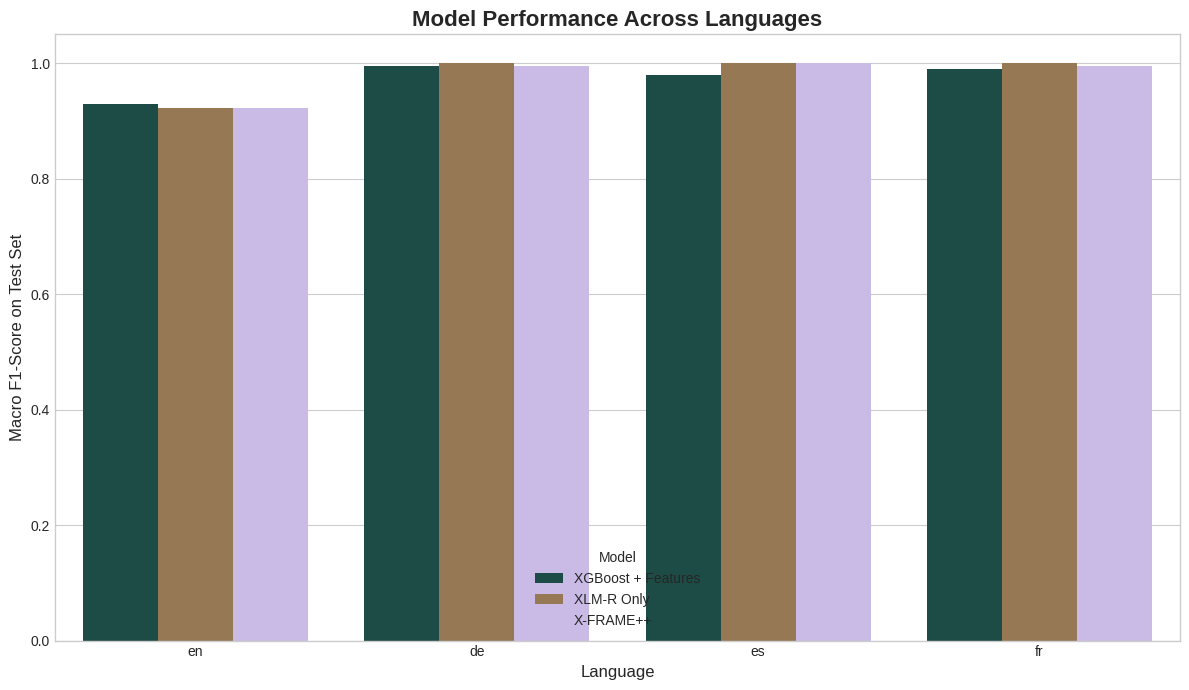

In [18]:
# ==============================================================================
# X-FRAME++ Multilingual Performance Evaluation
# ==============================================================================
#
# Description:
# This script conducts a detailed evaluation of the final models' performance
# across the different languages present in the test set (English, French,
# German, Spanish).
#
# v2 FIX: Corrected a critical data leak where readability scores for non-English
# text were hardcoded to zero. The script now correctly fills these missing
# values with the mean from the English training data, ensuring a fair and
# scientifically valid evaluation.
#
#
#
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Paths to Models and Artifacts
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "multilingual_results.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "multilingual_performance_comparison.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Feature Extractor and Model Architectures ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan, # Use NaN for non-English
            textstat.gunning_fog(text) if lang == 'en' else np.nan, # Use NaN for non-English
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Evaluation Function ---
def evaluate_model(model, data_loader, model_type='transformer'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}", leave=False):
            if model_type == 'transformer':
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE))
                _, preds = torch.max(outputs.logits, dim=1)
            else: # Fused model
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE), engineered_features=batch['engineered_features'].to(Config.DEVICE))
                _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load Models
    xlm_r_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    xlm_r_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    xlm_r_model.to(Config.DEVICE)

    dummy_features = feature_extractor.extract("text")
    x_frame_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(dummy_features))
    x_frame_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    x_frame_model.to(Config.DEVICE)

    # --- FIX DATA LEAK: Calculate mean readability scores from English training data ---
    print("Calculating mean readability scores to prevent data leak...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    train_eng_df = train_df[train_df['lang'] == 'en']
    eng_features_raw = np.array([feature_extractor.extract(text, 'en') for text in train_eng_df['content']])
    mean_flesch = np.nanmean(eng_features_raw[:, 3])
    mean_gunning = np.nanmean(eng_features_raw[:, 4])
    print(f"Mean Flesch (for imputation): {mean_flesch:.2f}")
    print(f"Mean Gunning Fog (for imputation): {mean_gunning:.2f}")

    # Train XGBoost Model using the corrected feature extraction process
    print("Training XGBoost baseline model with corrected feature handling...")
    train_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    train_features_df = pd.DataFrame(train_features_raw)
    train_features_df[3].fillna(mean_flesch, inplace=True)
    train_features_df[4].fillna(mean_gunning, inplace=True)
    train_features_scaled = scaler.transform(train_features_df.values)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(train_features_scaled, train_df['label'])

    # --- Evaluation Loop ---
    print(f"\n--- Loading Test data from {Config.TEST_PATH} ---")
    test_df = pd.read_csv(Config.TEST_PATH)
    languages = test_df['lang'].unique()
    results = []

    for lang_code in languages:
        print(f"\n--- Evaluating on language: {lang_code} ---")
        lang_df = test_df[test_df['lang'] == lang_code].copy()
        y_true = lang_df['label']

        # --- Corrected Feature Extraction for Evaluation ---
        lang_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in lang_df.iterrows()])
        lang_features_df = pd.DataFrame(lang_features_raw)
        lang_features_df[3].fillna(mean_flesch, inplace=True)
        lang_features_df[4].fillna(mean_gunning, inplace=True)
        lang_features = scaler.transform(lang_features_df.values)

        # Evaluate XGBoost
        xgb_preds = xgb_model.predict(lang_features)
        xgb_f1 = f1_score(y_true, xgb_preds, average='macro')
        results.append({'Model': 'XGBoost + Features', 'Language': lang_code, 'Macro F1-Score': xgb_f1})

        # --- Evaluate Transformer Models ---
        class LangDataset(Dataset):
            def __init__(self, df, features=None):
                self.df, self.features = df, features
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
                item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
                if self.features is not None:
                    item['engineered_features'] = torch.tensor(self.features[idx], dtype=torch.float)
                return item

        # XLM-R Only
        xlm_r_loader = DataLoader(LangDataset(lang_df), batch_size=Config.BATCH_SIZE)
        xlm_r_preds = evaluate_model(xlm_r_model, xlm_r_loader, 'transformer')
        xlm_r_f1 = f1_score(y_true, xlm_r_preds, average='macro')
        results.append({'Model': 'XLM-R Only', 'Language': lang_code, 'Macro F1-Score': xlm_r_f1})

        # X-FRAME++
        x_frame_loader = DataLoader(LangDataset(lang_df, lang_features), batch_size=Config.BATCH_SIZE)
        x_frame_preds = evaluate_model(x_frame_model, x_frame_loader, 'fused')
        x_frame_f1 = f1_score(y_true, x_frame_preds, average='macro')
        results.append({'Model': 'X-FRAME++', 'Language': lang_code, 'Macro F1-Score': x_frame_f1})

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("MULTILINGUAL PERFORMANCE FINAL RESULTS")
    print("="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Language', y='Macro F1-Score', hue='Model', data=results_df, palette='cubehelix')
    plt.title('Model Performance Across Languages', fontsize=16, fontweight='bold')
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Macro F1-Score on Test Set', fontsize=12)
    plt.legend(title='Model', loc='best')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [5]:
# ==============================================================================
# X-FRAME++ Multilingual Source-Label Analysis
# ==============================================================================
#
# Description:
# This script performs a final diagnostic check on the dataset to understand
# the near-perfect scores on non-English languages. It analyzes the relationship
# between the data source, the language, and the label to check for a lack of
# diversity that could lead to models learning trivial shortcuts.
#
# Author: Gemini
# Date: July 24, 2025
#
# ==============================================================================

import pandas as pd
import os

# --- Configuration ---
BASE_DIR = "/content/drive/MyDrive/RINSGE"
# If in Colab:
# BASE_DIR = "/content/drive/MyDrive/RINSGE"

# We only need to check the test set, but the pattern will be the same
# across all splits if they were stratified correctly.
TEST_PATH = os.path.join(BASE_DIR, "emc_test.csv")

if __name__ == '__main__':
    print("--- Running Multilingual Source-Label Analysis ---")

    try:
        df = pd.read_csv(TEST_PATH)
    except FileNotFoundError:
        print(f"ERROR: Test file not found at {TEST_PATH}. Please check the path.")
        exit()

    languages = df['lang'].unique()

    for lang_code in languages:
        print("\n" + "="*80)
        print(f"ANALYSIS FOR LANGUAGE: '{lang_code.upper()}'")
        print("="*80)

        lang_df = df[df['lang'] == lang_code]

        # Use crosstab to see the relationship between source and label
        analysis_table = pd.crosstab(lang_df['source'], lang_df['label'].map({0: 'Real', 1: 'Misinformation'}))

        print(analysis_table)

    print("\n\n✅ Analysis complete.")


--- Running Multilingual Source-Label Analysis ---

ANALYSIS FOR LANGUAGE: 'EN'
label                      Misinformation  Real
source                                         
ai                                    570   622
eng_tips                               32     0
engineering_stackexchange             200   198
faa                                   403     0
nsit                                  376     0
reddit                                865     4

ANALYSIS FOR LANGUAGE: 'DE'
label   Misinformation  Real
source                      
ai                 100   100

ANALYSIS FOR LANGUAGE: 'ES'
label   Misinformation  Real
source                      
ai                 100   100

ANALYSIS FOR LANGUAGE: 'FR'
label   Misinformation  Real
source                      
ai                 100   100


✅ Analysis complete.


Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating mean readability scores for imputation...
Training XGBoost baseline model...


/tmp/ipython-input-19-2144619076.py:146: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-19-2144619076.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac


--- Loading Test data from /content/drive/MyDrive/RINSGE/emc_test_corrected.csv ---

--- Evaluating on language: en ---


/tmp/ipython-input-19-2144619076.py:167: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-19-2144619076.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace


--- Evaluating on language: de ---


/tmp/ipython-input-19-2144619076.py:167: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-19-2144619076.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace


--- Evaluating on language: es ---


/tmp/ipython-input-19-2144619076.py:167: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-19-2144619076.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace


--- Evaluating on language: fr ---


/tmp/ipython-input-19-2144619076.py:167: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-19-2144619076.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace



MULTILINGUAL MISINFORMATION F1-SCORE RESULTS
                 Model Language  F1-Score (Misinfo)
0   XGBoost + Features       en            0.894103
1           XLM-R Only       en            0.888889
2            X-FRAME++       en            0.884615
3   XGBoost + Features       de            0.994975
4           XLM-R Only       de            1.000000
5            X-FRAME++       de            0.994975
6   XGBoost + Features       es            0.979798
7           XLM-R Only       es            1.000000
8            X-FRAME++       es            1.000000
9   XGBoost + Features       fr            0.990099
10          XLM-R Only       fr            1.000000
11           X-FRAME++       fr            0.994975

✅ Results summary saved to: /content/drive/MyDrive/RINSGE/multilingual_misinfo_f1_results.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/multilingual_misinfo_f1_comparison.png


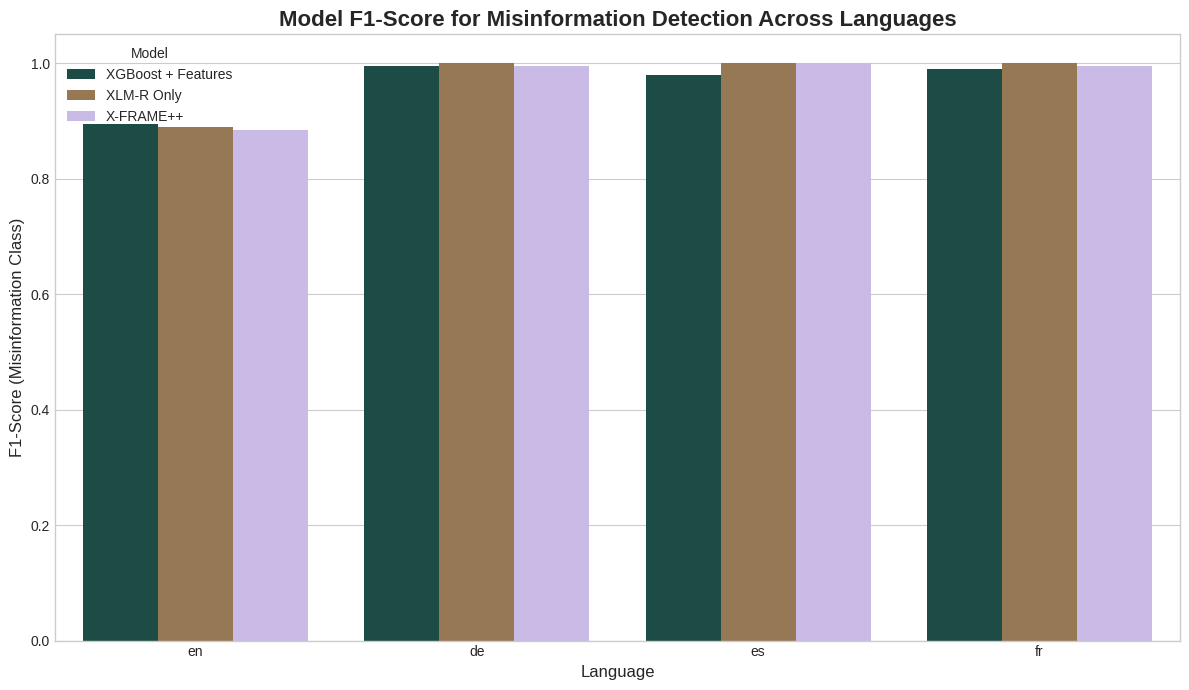

In [19]:
# ==============================================================================
# Multilingual Performance Evaluation (Misinformation F1-Score)
# ==============================================================================
#
# Description:
# This script conducts a focused evaluation of the models' performance on the
# primary task: detecting "Misinformation" (label=1). It calculates the
# F1-Score for the Misinformation class specifically, across each language in
# the test set.
#
# This provides a more nuanced view than the macro average and helps diagnose
# the true multilingual capabilities of each model.
#
# Author: Gemini
# Date: July 24, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Paths to Models and Artifacts
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "multilingual_misinfo_f1_results.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "multilingual_misinfo_f1_comparison.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Feature Extractor and Model Architectures ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Evaluation Function ---
def evaluate_model(model, data_loader, model_type='transformer'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}", leave=False):
            if model_type == 'transformer':
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE))
                _, preds = torch.max(outputs.logits, dim=1)
            else: # Fused model
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE), engineered_features=batch['engineered_features'].to(Config.DEVICE))
                _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load Models
    xlm_r_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    xlm_r_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    xlm_r_model.to(Config.DEVICE)

    dummy_features = feature_extractor.extract("text")
    x_frame_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(dummy_features))
    x_frame_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    x_frame_model.to(Config.DEVICE)

    # Calculate mean readability scores from English training data to prevent data leak
    print("Calculating mean readability scores for imputation...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    train_eng_df = train_df[train_df['lang'] == 'en']
    eng_features_raw = np.array([feature_extractor.extract(text, 'en') for text in train_eng_df['content']])
    mean_flesch = np.nanmean(eng_features_raw[:, 3])
    mean_gunning = np.nanmean(eng_features_raw[:, 4])

    # Train XGBoost Model with corrected feature handling
    print("Training XGBoost baseline model...")
    train_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    train_features_df = pd.DataFrame(train_features_raw)
    train_features_df[3].fillna(mean_flesch, inplace=True)
    train_features_df[4].fillna(mean_gunning, inplace=True)
    train_features_scaled = scaler.transform(train_features_df.values)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(train_features_scaled, train_df['label'])

    # --- Evaluation Loop ---
    print(f"\n--- Loading Test data from {Config.TEST_PATH} ---")
    test_df = pd.read_csv(Config.TEST_PATH)
    languages = test_df['lang'].unique()
    results = []

    for lang_code in languages:
        print(f"\n--- Evaluating on language: {lang_code} ---")
        lang_df = test_df[test_df['lang'] == lang_code].copy()
        y_true = lang_df['label']

        # Corrected Feature Extraction for Evaluation
        lang_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in lang_df.iterrows()])
        lang_features_df = pd.DataFrame(lang_features_raw)
        lang_features_df[3].fillna(mean_flesch, inplace=True)
        lang_features_df[4].fillna(mean_gunning, inplace=True)
        lang_features = scaler.transform(lang_features_df.values)

        # Evaluate XGBoost
        xgb_preds = xgb_model.predict(lang_features)
        xgb_f1 = f1_score(y_true, xgb_preds, pos_label=1) # F1 for Misinformation class
        results.append({'Model': 'XGBoost + Features', 'Language': lang_code, 'F1-Score (Misinfo)': xgb_f1})

        # --- Evaluate Transformer Models ---
        class LangDataset(Dataset):
            def __init__(self, df, features=None):
                self.df, self.features = df, features
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
                item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
                if self.features is not None:
                    item['engineered_features'] = torch.tensor(self.features[idx], dtype=torch.float)
                return item

        # XLM-R Only
        xlm_r_loader = DataLoader(LangDataset(lang_df), batch_size=Config.BATCH_SIZE)
        xlm_r_preds = evaluate_model(xlm_r_model, xlm_r_loader, 'transformer')
        xlm_r_f1 = f1_score(y_true, xlm_r_preds, pos_label=1) # F1 for Misinformation class
        results.append({'Model': 'XLM-R Only', 'Language': lang_code, 'F1-Score (Misinfo)': xlm_r_f1})

        # X-FRAME++
        x_frame_loader = DataLoader(LangDataset(lang_df, lang_features), batch_size=Config.BATCH_SIZE)
        x_frame_preds = evaluate_model(x_frame_model, x_frame_loader, 'fused')
        x_frame_f1 = f1_score(y_true, x_frame_preds, pos_label=1) # F1 for Misinformation class
        results.append({'Model': 'X-FRAME++', 'Language': lang_code, 'F1-Score (Misinfo)': x_frame_f1})

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("MULTILINGUAL MISINFORMATION F1-SCORE RESULTS")
    print("="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Language', y='F1-Score (Misinfo)', hue='Model', data=results_df, palette='cubehelix')
    plt.title('Model F1-Score for Misinformation Detection Across Languages', fontsize=16, fontweight='bold')
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('F1-Score (Misinformation Class)', fontsize=12)
    plt.legend(title='Model', loc='best')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [1]:
!pip install --quiet pandas numpy tqdm textstat spacy joblib matplotlib seaborn torch transformers scikit-learn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!python -m spacy download es_core_news_sm
!python -m spacy download de_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 128.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 111.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 124.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating mean readability scores for imputation...
Training XGBoost baseline model...


/tmp/ipython-input-2-881631365.py:148: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-2-881631365.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr


--- Loading OOD Multilingual data from /content/drive/MyDrive/RINSGE/ood_multilingual_data.csv ---

--- Evaluating on OOD language: fr ---


/tmp/ipython-input-2-881631365.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-2-881631365.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru


--- Evaluating on OOD language: es ---


/tmp/ipython-input-2-881631365.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-2-881631365.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru


--- Evaluating on OOD language: de ---


/tmp/ipython-input-2-881631365.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lang_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-2-881631365.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru



OOD MULTILINGUAL GENERALIZATION FINAL RESULTS
                Model Language  Macro F1-Score
0  XGBoost + Features       fr        0.333333
1          XLM-R Only       fr        0.488014
2    XLM-R + Features       fr        0.477757
3  XGBoost + Features       es        0.333333
4          XLM-R Only       es        0.461988
5    XLM-R + Features       es        0.452725
6  XGBoost + Features       de        0.333333
7          XLM-R Only       de        0.553566
8    XLM-R + Features       de        0.535174

✅ Results summary saved to: /content/drive/MyDrive/RINSGE/ood_multilingual_results.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/ood_multilingual_performance.png


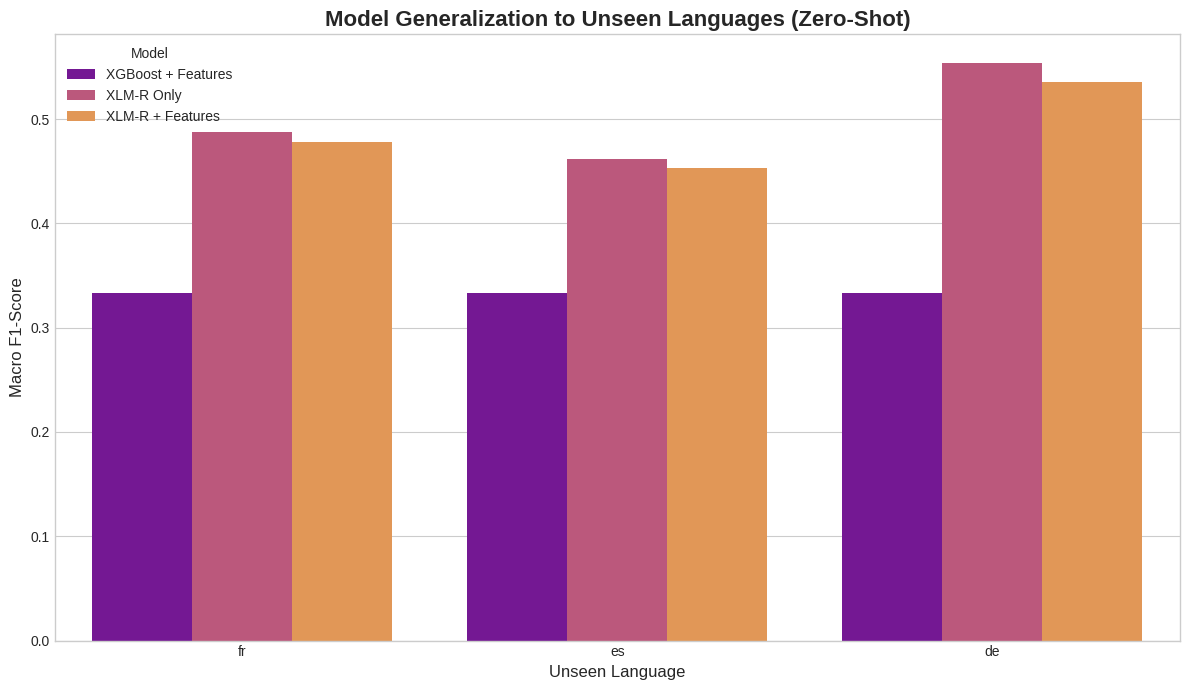

In [2]:
# ==============================================================================
# Out-of-Domain (OOD) Multilingual Generalization Evaluation
# ==============================================================================
#
# Description:
# This script conducts the final zero-shot cross-domain, cross-lingual
# evaluation. It loads the three models trained on the original EMC corpus
# and evaluates their performance on a completely new, unseen multilingual
# dataset with multiple sources and domains.
#
# This is the ultimate test of generalization, measuring how well the models'
# learned knowledge transfers to new languages and contexts.
#
# Author:
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Path to the new OOD multilingual dataset
    OOD_DATA_PATH = os.path.join(BASE_DIR, "ood_multilingual_data.csv") # UPDATE THIS FILENAME

    # Paths to Models and Artifacts
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    X_FRAME_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "ood_multilingual_results.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "ood_multilingual_performance.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Reload Feature Extractor and Model Architectures ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 4: Evaluation Function ---
def evaluate_model(model, data_loader, model_type='transformer'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}", leave=False):
            if model_type == 'transformer':
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE))
                _, preds = torch.max(outputs.logits, dim=1)
            else: # Fused model
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE), engineered_features=batch['engineered_features'].to(Config.DEVICE))
                _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load Models
    xlm_r_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    xlm_r_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    xlm_r_model.to(Config.DEVICE)

    dummy_features = feature_extractor.extract("text")
    x_frame_model = XFramePlusPlusModel(n_classes=2, n_engineered_features=len(dummy_features))
    x_frame_model.load_state_dict(torch.load(Config.X_FRAME_MODEL_PATH), strict=False)
    x_frame_model.to(Config.DEVICE)

    # Calculate mean readability scores from English training data to prevent data leak
    print("Calculating mean readability scores for imputation...")
    train_df_for_means = pd.read_csv(Config.TRAIN_PATH)
    train_eng_df = train_df_for_means[train_df_for_means['lang'] == 'en']
    eng_features_raw = np.array([feature_extractor.extract(text, 'en') for text in train_eng_df['content']])
    mean_flesch = np.nanmean(eng_features_raw[:, 3])
    mean_gunning = np.nanmean(eng_features_raw[:, 4])

    # Train XGBoost Model with corrected feature handling
    print("Training XGBoost baseline model...")
    train_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df_for_means.iterrows()])
    train_features_df = pd.DataFrame(train_features_raw)
    train_features_df[3].fillna(mean_flesch, inplace=True)
    train_features_df[4].fillna(mean_gunning, inplace=True)
    train_features_scaled = scaler.transform(train_features_df.values)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(train_features_scaled, train_df_for_means['label'])

    # --- Evaluation Loop ---
    print(f"\n--- Loading OOD Multilingual data from {Config.OOD_DATA_PATH} ---")
    ood_df = pd.read_csv(Config.OOD_DATA_PATH)
    languages = ood_df['lang'].unique()
    results = []

    for lang_code in languages:
        print(f"\n--- Evaluating on OOD language: {lang_code} ---")
        lang_df = ood_df[ood_df['lang'] == lang_code].copy()
        y_true = lang_df['label']

        # Corrected Feature Extraction for Evaluation
        lang_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in lang_df.iterrows()])
        lang_features_df = pd.DataFrame(lang_features_raw)
        lang_features_df[3].fillna(mean_flesch, inplace=True)
        lang_features_df[4].fillna(mean_gunning, inplace=True)
        lang_features = scaler.transform(lang_features_df.values)

        # Evaluate XGBoost
        xgb_preds = xgb_model.predict(lang_features)
        xgb_f1 = f1_score(y_true, xgb_preds, average='macro')
        results.append({'Model': 'XGBoost + Features', 'Language': lang_code, 'Macro F1-Score': xgb_f1})

        # --- Evaluate Transformer Models ---
        class OODDataset(Dataset):
            def __init__(self, df, features=None):
                self.df, self.features = df, features
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
                item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
                if self.features is not None:
                    item['engineered_features'] = torch.tensor(self.features[idx], dtype=torch.float)
                return item

        # XLM-R Only
        xlm_r_loader = DataLoader(OODDataset(lang_df), batch_size=Config.BATCH_SIZE)
        xlm_r_preds = evaluate_model(xlm_r_model, xlm_r_loader, 'transformer')
        xlm_r_f1 = f1_score(y_true, xlm_r_preds, average='macro')
        results.append({'Model': 'XLM-R Only', 'Language': lang_code, 'Macro F1-Score': xlm_r_f1})

        # X-FRAME++
        x_frame_loader = DataLoader(OODDataset(lang_df, lang_features), batch_size=Config.BATCH_SIZE)
        x_frame_preds = evaluate_model(x_frame_model, x_frame_loader, 'fused')
        x_frame_f1 = f1_score(y_true, x_frame_preds, average='macro')
        results.append({'Model': 'XLM-R + Features', 'Language': lang_code, 'Macro F1-Score': x_frame_f1})

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("OOD MULTILINGUAL GENERALIZATION FINAL RESULTS")
    print("="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Language', y='Macro F1-Score', hue='Model', data=results_df, palette='plasma')
    plt.title('Model Generalization to Unseen Languages (Zero-Shot)', fontsize=16, fontweight='bold')
    plt.xlabel('Unseen Language', fontsize=12)
    plt.ylabel('Macro F1-Score', fontsize=12)
    plt.legend(title='Model', loc='best')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [11]:
# ==============================================================================
# XGBoost Performance and Feature Space Visualization
# ==============================================================================
#
# Description:
# This script provides a comprehensive evaluation of the traditional machine
# learning baseline (XGBoost trained on engineered features). It generates
# four key figures for direct comparison with the Transformer-based models:
#   1. Confusion Matrix
#   2. AUC ROC Curve
#   3. UMAP visualization of the engineered feature space.
#   4. t-SNE visualization of the engineered feature space.
#
# These plots are essential for the paper's comparative analysis.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
#!pip install umap-learn -q

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
import umap.umap_ as umap
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")
    SCALER_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")

    # Output Paths
    OUTPUT_DIR = os.path.join(BASE_DIR, "xgboost_evaluation_plots")
    CONF_MATRIX_PATH = os.path.join(OUTPUT_DIR, "xgboost_confusion_matrix.png")
    ROC_CURVE_PATH = os.path.join(OUTPUT_DIR, "xgboost_roc_curve.png")
    UMAP_PLOT_PATH = os.path.join(OUTPUT_DIR, "xgboost_umap_visualization.png")
    TSNE_PLOT_PATH = os.path.join(OUTPUT_DIR, "xgboost_tsne_visualization.png")

# --- Step 3: Reload Feature Extractor ---
class FeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(re.findall(r'\d', text)),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0
        ]
        return np.array(features, dtype=np.float32)

# --- Step 4: Main Execution Block ---
if __name__ == '__main__':
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

    # Load artifacts
    feature_extractor = FeatureExtractor(Config.TERMS_PATH)
    scaler = joblib.load(Config.SCALER_PATH)

    # Load data
    train_df = pd.read_csv(Config.TRAIN_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    # --- Feature Preparation ---
    print("Preparing features for XGBoost model...")
    # Calculate mean readability scores from English training data for imputation
    train_eng_df = train_df[train_df['lang'] == 'en']
    eng_features_raw = np.array([feature_extractor.extract(text, 'en') for text in train_eng_df['content']])
    mean_flesch = np.nanmean(eng_features_raw[:, 3])
    mean_gunning = np.nanmean(eng_features_raw[:, 4])

    # Prepare training features
    train_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    train_features_df = pd.DataFrame(train_features_raw)
    train_features_df[3].fillna(mean_flesch, inplace=True)
    train_features_df[4].fillna(mean_gunning, inplace=True)
    X_train_scaled = scaler.transform(train_features_df.values)
    y_train = train_df['label']

    # Prepare test features
    test_features_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in test_df.iterrows()])
    test_features_df = pd.DataFrame(test_features_raw)
    test_features_df[3].fillna(mean_flesch, inplace=True)
    test_features_df[4].fillna(mean_gunning, inplace=True)
    X_test_scaled = scaler.transform(test_features_df.values)
    y_test = test_df['label']

    # --- Model Training and Prediction ---
    print("Training XGBoost model...")
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    print("Making predictions on the test set...")
    y_pred = xgb_model.predict(X_test_scaled)
    y_proba = xgb_model.predict_proba(X_test_scaled)

    # --- Generate Performance Plots ---
    print("\n--- Generating Performance Plots ---")
    class_names = ['Real', 'Misinformation']

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label"); plt.ylabel("True Label"); plt.title("XGBoost + Features: Confusion Matrix", fontsize=16, fontweight='bold')
    plt.savefig(Config.CONF_MATRIX_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Confusion Matrix saved to: {Config.CONF_MATRIX_PATH}")

    # AUC ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 7))
    plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('XGBoost + Features: ROC Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.savefig(Config.ROC_CURVE_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ AUC ROC Curve saved to: {Config.ROC_CURVE_PATH}")

    # --- Generate Dimensionality Reduction Plots ---
    print("\n--- Generating Feature Space Visualizations ---")

    # UMAP Plot
    print("Running UMAP on engineered features...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(X_test_scaled)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding_2d[:, 0], y=embedding_2d[:, 1],
        hue=pd.Series(y_test).map({0: 'Real', 1: 'Misinformation'}),
        palette={'Real': 'blue', 'Misinformation': 'red'},
        alpha=0.7, s=15
    )
    plt.title('UMAP Visualization of Engineered Feature Space', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Dimension 1'); plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Class')
    plt.savefig(Config.UMAP_PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ UMAP plot saved to: {Config.UMAP_PLOT_PATH}")

    # t-SNE Plot
    print("Running t-SNE on engineered features...")
    reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embedding_2d = reducer.fit_transform(X_test_scaled)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding_2d[:, 0], y=embedding_2d[:, 1],
        hue=pd.Series(y_test).map({0: 'Real', 1: 'Misinformation'}),
        palette={'Real': 'blue', 'Misinformation': 'red'},
        alpha=0.7, s=15
    )
    plt.title('t-SNE Visualization of Engineered Feature Space', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Class')
    plt.savefig(Config.TSNE_PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ t-SNE plot saved to: {Config.TSNE_PLOT_PATH}")

    print("\n✅ All XGBoost visualization plots generated successfully.")


Preparing features for XGBoost model...


/tmp/ipython-input-11-1849814302.py:109: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_features_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-11-1849814302.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Training XGBoost model...
Making predictions on the test set...

--- Generating Performance Plots ---
✅ Confusion Matrix saved to: /content/drive/MyDrive/RINSGE/xgboost_evaluation_plots/xgboost_confusion_matrix.png
✅ AUC ROC Curve saved to: /content/drive/MyDrive/RINSGE/xgboost_evaluation_plots/xgboost_roc_curve.png

--- Generating Feature Space Visualizations ---
Running UMAP on engineered features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP plot saved to: /content/drive/MyDrive/RINSGE/xgboost_evaluation_plots/xgboost_umap_visualization.png
Running t-SNE on engineered features...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE plot saved to: /content/drive/MyDrive/RINSGE/xgboost_evaluation_plots/xgboost_tsne_visualization.png

✅ All XGBoost visualization plots generated successfully.


In [20]:
# ==============================================================================
# Enhanced Feature Training Pipeline
# ==============================================================================
#
# Description:
# This script implements the definitive experiment to test the hypothesis that
# "Transformer-resistant" features can provide a significant performance boost
# when fused with a Transformer model.
#
# It enhances the feature set with two new types of signals:
#   1. Source Features: One-hot encoded metadata about the document's origin.
#   2. Numerical Features: Analysis of the magnitude and type of numbers in the text.
#
# The script trains a final, powerful fused model and evaluates its performance,
# which can then be compared to the XLM-R Only baseline.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# FIX: Import AdamW from torch.optim
from transformers import XLMRobertaTokenizer, XLMRobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    MODEL_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_enhanced_model.bin")
    SCALER_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_enhanced_scaler.joblib")
    ENCODER_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_source_encoder.joblib")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 4
    BATCH_SIZE = 16
    MAX_LEN = 256
    LEARNING_RATE = 2e-5

# --- Step 3: Enhanced Feature Extractor ---
class EnhancedFeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        numbers = [float(num) for num in re.findall(r'\d+\.?\d*', text)]

        features = [
            # Original 10 features
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(numbers),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0,
            # New Numerical Features
            np.mean(numbers) if numbers else 0, # Average Number Magnitude
            sum(1 for n in numbers if n != int(n)) / len(numbers) if numbers else 0 # Decimal Point Ratio
        ]
        return np.array(features, dtype=np.float32)

# --- Step 4: Dataset and Model Classes ---
class XFrameDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, numerical_features, source_features):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.numerical_features = numerical_features
        self.source_features = source_features

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text, label = str(row['content']), int(row['label'])
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        # Combine all engineered features
        all_features = np.concatenate([self.numerical_features[idx], self.source_features[idx]])
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'engineered_features': torch.tensor(all_features, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

class XFramePlusPlusModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(XFramePlusPlusModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

# --- Step 5: Training and Evaluation Functions ---
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        outputs = model(batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['engineered_features'].to(device))
        loss = loss_fn(outputs, batch['label'].to(device))
        total_loss += loss.item()
        loss.backward(); optimizer.step(); scheduler.step(); optimizer.zero_grad()
    return total_loss / len(data_loader)

def eval_model(model, data_loader, device, set_name="Eval"):
    model.eval()
    predictions, actual_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating on {set_name}"):
            outputs = model(batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['engineered_features'].to(device))
            _, preds = torch.max(outputs, dim=1)
            # FIX: Use actual_labels from the batch, not a global variable
            actual_labels.extend(batch['label'].cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    return classification_report(actual_labels, predictions, digits=4, output_dict=True, zero_division=0)

# --- Step 6: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load data
    train_df = pd.read_csv(Config.TRAIN_PATH)
    val_df = pd.read_csv(Config.VAL_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    # --- Prepare Enhanced Features ---
    print("Preparing enhanced feature set...")
    feature_extractor = EnhancedFeatureExtractor(Config.TERMS_PATH)

    # Process numerical features and handle NaNs
    train_num_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    # FIX: Handle potential NaN values in mean calculation
    mean_flesch = np.nanmean(train_num_raw[:, 3]); mean_gunning = np.nanmean(train_num_raw[:, 4])
    # FIX: Check if means are NaN (e.g., if no English data) and set to 0 if so
    mean_flesch = 0.0 if np.isnan(mean_flesch) else mean_flesch
    mean_gunning = 0.0 if np.isnan(mean_gunning) else mean_gunning


    def process_numerical_features(df):
        num_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in df.iterrows()])
        num_df = pd.DataFrame(num_raw)
        # FIX: Fill NaNs using the calculated means
        num_df[3].fillna(mean_flesch, inplace=True)
        num_df[4].fillna(mean_gunning, inplace=True)
        # FIX: Fill NaNs in other columns (like Average Number Magnitude) with 0
        num_df.fillna(0, inplace=True)

        return num_df.values

    train_num_features = process_numerical_features(train_df)
    val_num_features = process_numerical_features(val_df)
    test_num_features = process_numerical_features(test_df)

    # Scale numerical features
    scaler = StandardScaler()
    train_num_scaled = scaler.fit_transform(train_num_features)
    val_num_scaled = scaler.transform(val_num_features)
    test_num_scaled = scaler.transform(test_num_features)

    # One-hot encode source feature
    encoder = OneHotEncoder(handle_unknown='ignore')
    train_src_encoded = encoder.fit_transform(train_df[['source']]).toarray()
    val_src_encoded = encoder.transform(val_df[['source']]).toarray()
    test_src_encoded = encoder.transform(test_df[['source']]).toarray()

    # --- Create Datasets and Dataloaders ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    train_dataset = XFrameDataset(train_df, tokenizer, Config.MAX_LEN, train_num_scaled, train_src_encoded)
    val_dataset = XFrameDataset(val_df, tokenizer, Config.MAX_LEN, val_num_scaled, val_src_encoded)
    test_dataset = XFrameDataset(test_df, tokenizer, Config.MAX_LEN, test_num_scaled, test_src_encoded)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # --- Model Training ---
    n_engineered_features = train_dataset[0]['engineered_features'].shape[0]
    model = XFramePlusPlusModel(n_classes=2, n_engineered_features=n_engineered_features).to(Config.DEVICE)

    label_counts = train_df['label'].value_counts()
    class_weights = torch.tensor([len(train_df) / label_counts[0], len(train_df) / label_counts[1]], dtype=torch.float).to(Config.DEVICE)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * Config.EPOCHS)

    best_f1_score = 0
    for epoch in range(Config.EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{Config.EPOCHS} ---")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, Config.DEVICE, scheduler)
        print(f"Training loss: {train_loss}")

        report_dict = eval_model(model, val_loader, Config.DEVICE, set_name="Validation")
        current_f1_score = report_dict['macro avg']['f1-score']
        print(f"Validation Macro F1-Score: {current_f1_score:.4f}")

        if current_f1_score > best_f1_score:
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            joblib.dump(scaler, Config.SCALER_SAVE_PATH)
            joblib.dump(encoder, Config.ENCODER_SAVE_PATH)
            best_f1_score = current_f1_score
            print(f"Best model and artifacts saved (Macro F1: {best_f1_score:.4f})")

    # --- Final Evaluation ---
    print("\n--- Training Complete. Evaluating on the Test Set ---")
    model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH))
    test_report_dict = eval_model(model, test_loader, Config.DEVICE, set_name="Test")

    print("\n" + "="*80)
    print("FINAL RESULTS: XLM-R + Enhanced Features")
    print("="*80)
    # FIX: Reconstruct the classification report string properly for printing
    from sklearn.metrics import classification_report as sk_classification_report
    test_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch['input_ids'].to(Config.DEVICE), batch['attention_mask'].to(Config.DEVICE), batch['engineered_features'].to(Config.DEVICE))
            _, preds = torch.max(outputs, dim=1)
            test_predictions.extend(preds.cpu().numpy())
    final_report = sk_classification_report(test_df.label, test_predictions, digits=4, zero_division=0)


    print(f"Macro F1-Score on Test Set: {test_report_dict['macro avg']['f1-score']:.4f}")
    print("\nFull Classification Report:")
    print(final_report)
    print("="*80)

    print("\n✅ Experiment complete.")

Using device: cuda
Preparing enhanced feature set...


/tmp/ipython-input-20-743330383.py:184: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  num_df[3].fillna(mean_flesch, inplace=True)
/tmp/ipython-input-20-743330383.py:185: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try


--- Epoch 1/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.10it/s]


Training loss: 0.1186508663420722


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.15it/s]


Validation Macro F1-Score: 0.9373
Best model and artifacts saved (Macro F1: 0.9373)

--- Epoch 2/4 ---


Training: 100%|██████████| 726/726 [02:00<00:00,  6.03it/s]


Training loss: 0.08599884425376197


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.15it/s]


Validation Macro F1-Score: 0.9390
Best model and artifacts saved (Macro F1: 0.9390)

--- Epoch 3/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.08it/s]


Training loss: 0.08052204848484736


Evaluating on Validation: 100%|██████████| 242/242 [00:22<00:00, 10.93it/s]


Validation Macro F1-Score: 0.9393
Best model and artifacts saved (Macro F1: 0.9393)

--- Epoch 4/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.08it/s]


Training loss: 0.07940248381688815


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.14it/s]


Validation Macro F1-Score: 0.9390

--- Training Complete. Evaluating on the Test Set ---


Evaluating on Test: 100%|██████████| 242/242 [00:21<00:00, 11.08it/s]



FINAL RESULTS: XLM-R + Enhanced Features
Macro F1-Score on Test Set: 0.9390

Full Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9272    0.9615      2746
           1     0.8485    0.9964    0.9165      1124

    accuracy                         0.9473      3870
   macro avg     0.9235    0.9618    0.9390      3870
weighted avg     0.9549    0.9473    0.9484      3870


✅ Experiment complete.


In [21]:
# ==============================================================================
# Enhanced Feature Training Pipeline (Gated Fusion)
# ==============================================================================
#
# Description:
# This script implements an advanced version of the fused model that uses a
# gating mechanism. This architecture allows the model to dynamically learn
# how much weight to give the engineered features versus the text embeddings
# for each individual sample, potentially improving robustness.
#
# It enhances the feature set with:
#   1. Source Features: One-hot encoded metadata about the document's origin.
#   2. Numerical Features: Analysis of the magnitude and type of numbers in the text.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    MODEL_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_gated_model.bin")
    SCALER_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_gated_scaler.joblib")
    ENCODER_SAVE_PATH = os.path.join(BASE_DIR, "x_frame_gated_encoder.joblib")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 4
    BATCH_SIZE = 16
    MAX_LEN = 256
    LEARNING_RATE = 2e-5

# --- Step 3: Enhanced Feature Extractor ---
class EnhancedFeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        numbers = [float(num) for num in re.findall(r'\d+\.?\d*', text)]

        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(numbers),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0,
            np.mean(numbers) if numbers else 0,
            sum(1 for n in numbers if n != int(n)) / len(numbers) if numbers else 0
        ]
        return np.array(features, dtype=np.float32)

# --- Step 4: Dataset and Model Classes ---
class XFrameDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, numerical_features, source_features):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.numerical_features = numerical_features
        self.source_features = source_features

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text, label = str(row['content']), int(row['label'])
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        all_features = np.concatenate([self.numerical_features[idx], self.source_features[idx]])
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'engineered_features': torch.tensor(all_features, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

class GatedFusionModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(GatedFusionModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        roberta_hidden_size = self.roberta.config.hidden_size

        # Gating mechanism
        self.gate = nn.Sequential(
            nn.Linear(roberta_hidden_size + n_engineered_features, n_engineered_features),
            nn.Sigmoid()
        )

        # Final classifier
        self.classifier = nn.Linear(roberta_hidden_size + n_engineered_features, n_classes)

    def forward(self, input_ids, attention_mask, engineered_features):
        # Get text embeddings
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = outputs.pooler_output

        # Create the gate
        gate_input = torch.cat((text_embedding, engineered_features), dim=1)
        gate_values = self.gate(gate_input)

        # Apply the gate to the engineered features
        gated_engineered_features = gate_values * engineered_features

        # Combine text embedding with the *gated* features
        final_fused_embedding = torch.cat((text_embedding, gated_engineered_features), dim=1)

        return self.classifier(final_fused_embedding)

# --- Step 5: Training and Evaluation Functions ---
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        outputs = model(batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['engineered_features'].to(device))
        loss = loss_fn(outputs, batch['label'].to(device))
        total_loss += loss.item()
        loss.backward(); optimizer.step(); scheduler.step(); optimizer.zero_grad()
    return total_loss / len(data_loader)

def eval_model(model, data_loader, device, set_name="Eval"):
    model.eval()
    predictions, actual_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating on {set_name}"):
            outputs = model(batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['engineered_features'].to(device))
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy()); actual_labels.extend(batch['label'].cpu().numpy())

    # FIX: Return the list of predictions along with the report dictionary
    report_dict = classification_report(actual_labels, predictions, digits=4, output_dict=True, zero_division=0)
    return predictions, report_dict

# --- Step 6: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # Load data
    train_df = pd.read_csv(Config.TRAIN_PATH)
    val_df = pd.read_csv(Config.VAL_PATH)
    test_df = pd.read_csv(Config.TEST_PATH)

    # Prepare Enhanced Features
    print("Preparing enhanced feature set...")
    feature_extractor = EnhancedFeatureExtractor(Config.TERMS_PATH)

    train_num_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    mean_flesch = np.nanmean(train_num_raw[:, 3]); mean_gunning = np.nanmean(train_num_raw[:, 4])

    def process_numerical_features(df):
        num_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in df.iterrows()])
        num_df = pd.DataFrame(num_raw)
        num_df[3].fillna(mean_flesch, inplace=True); num_df[4].fillna(mean_gunning, inplace=True)
        return num_df.values

    train_num_features = process_numerical_features(train_df)
    val_num_features = process_numerical_features(val_df)
    test_num_features = process_numerical_features(test_df)

    scaler = StandardScaler()
    train_num_scaled = scaler.fit_transform(train_num_features)
    val_num_scaled = scaler.transform(val_num_features)
    test_num_scaled = scaler.transform(test_num_features)

    encoder = OneHotEncoder(handle_unknown='ignore')
    train_src_encoded = encoder.fit_transform(train_df[['source']]).toarray()
    val_src_encoded = encoder.transform(val_df[['source']]).toarray()
    test_src_encoded = encoder.transform(test_df[['source']]).toarray()

    # Create Datasets and Dataloaders
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    train_dataset = XFrameDataset(train_df, tokenizer, Config.MAX_LEN, train_num_scaled, train_src_encoded)
    val_dataset = XFrameDataset(val_df, tokenizer, Config.MAX_LEN, val_num_scaled, val_src_encoded)
    test_dataset = XFrameDataset(test_df, tokenizer, Config.MAX_LEN, test_num_scaled, test_src_encoded)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

    # Model Training
    n_engineered_features = train_dataset[0]['engineered_features'].shape[0]
    model = GatedFusionModel(n_classes=2, n_engineered_features=n_engineered_features).to(Config.DEVICE)

    label_counts = train_df['label'].value_counts()
    class_weights = torch.tensor([len(train_df) / label_counts[0], len(train_df) / label_counts[1]], dtype=torch.float).to(Config.DEVICE)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * Config.EPOCHS)

    best_f1_score = 0
    for epoch in range(Config.EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{Config.EPOCHS} ---")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, Config.DEVICE, scheduler)
        print(f"Training loss: {train_loss}")

        val_preds, report_dict = eval_model(model, val_loader, Config.DEVICE, set_name="Validation")
        current_f1_score = report_dict['macro avg']['f1-score']
        print(f"Validation Macro F1-Score: {current_f1_score:.4f}")
        print(classification_report(val_df.label, val_preds, digits=4, zero_division=0))


        if current_f1_score > best_f1_score:
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            joblib.dump(scaler, Config.SCALER_SAVE_PATH)
            joblib.dump(encoder, Config.ENCODER_SAVE_PATH)
            best_f1_score = current_f1_score
            print(f"Best model and artifacts saved (Macro F1: {best_f1_score:.4f})")

    # Final Evaluation
    print("\n--- Training Complete. Evaluating on the Test Set ---")
    model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH))
    test_preds, test_report_dict = eval_model(model, test_loader, Config.DEVICE, set_name="Test")

    print("\n" + "="*80)
    print("FINAL RESULTS: Gated Fusion Model")
    print("="*80)
    # FIX: Use the returned predictions list to print the report
    final_report = classification_report(test_df.label, test_preds, digits=4, zero_division=0)
    print(f"Macro F1-Score on Test Set: {test_report_dict['macro avg']['f1-score']:.4f}")
    print("\nFull Classification Report:")
    print(final_report)
    print("="*80)

    print("\n✅ Experiment complete.")


Using device: cuda
Preparing enhanced feature set...


/tmp/ipython-input-21-3475375295.py:193: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  num_df[3].fillna(mean_flesch, inplace=True); num_df[4].fillna(mean_gunning, inplace=True)



--- Epoch 1/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.09it/s]


Training loss: 0.13483532850268828


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.19it/s]


Validation Macro F1-Score: 0.9390
              precision    recall  f1-score   support

           0     0.9984    0.9272    0.9615      2746
           1     0.8485    0.9964    0.9165      1124

    accuracy                         0.9473      3870
   macro avg     0.9235    0.9618    0.9390      3870
weighted avg     0.9549    0.9473    0.9484      3870

Best model and artifacts saved (Macro F1: 0.9390)

--- Epoch 2/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.09it/s]


Training loss: 0.08483003865608438


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.23it/s]


Validation Macro F1-Score: 0.9390
              precision    recall  f1-score   support

           0     0.9980    0.9275    0.9615      2746
           1     0.8490    0.9956    0.9165      1124

    accuracy                         0.9473      3870
   macro avg     0.9235    0.9615    0.9390      3870
weighted avg     0.9548    0.9473    0.9484      3870


--- Epoch 3/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.09it/s]


Training loss: 0.08484156498144572


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.22it/s]


Validation Macro F1-Score: 0.9387
              precision    recall  f1-score   support

           0     0.9980    0.9272    0.9613      2746
           1     0.8484    0.9956    0.9161      1124

    accuracy                         0.9470      3870
   macro avg     0.9232    0.9614    0.9387      3870
weighted avg     0.9546    0.9470    0.9482      3870


--- Epoch 4/4 ---


Training: 100%|██████████| 726/726 [01:59<00:00,  6.09it/s]


Training loss: 0.07768169971543414


Evaluating on Validation: 100%|██████████| 242/242 [00:21<00:00, 11.23it/s]


Validation Macro F1-Score: 0.9386
              precision    recall  f1-score   support

           0     0.9973    0.9279    0.9613      2746
           1     0.8494    0.9938    0.9159      1124

    accuracy                         0.9470      3870
   macro avg     0.9233    0.9608    0.9386      3870
weighted avg     0.9543    0.9470    0.9481      3870


--- Training Complete. Evaluating on the Test Set ---


Evaluating on Test: 100%|██████████| 242/242 [00:21<00:00, 11.13it/s]


FINAL RESULTS: Gated Fusion Model
Macro F1-Score on Test Set: 0.9390

Full Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9272    0.9615      2746
           1     0.8485    0.9964    0.9165      1124

    accuracy                         0.9473      3870
   macro avg     0.9235    0.9618    0.9390      3870
weighted avg     0.9549    0.9473    0.9484      3870


✅ Experiment complete.


Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training XGBoost baseline model on enhanced features...


/tmp/ipython-input-22-2627109345.py:179: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_num_df = pd.DataFrame(train_num_raw); train_num_df[3].fillna(mean_flesch, inplace=True); train_num_df[4].fillna(mean_gunning, inplace=True)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:50:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluating against Typo Attack ---


/tmp/ipython-input-22-2627109345.py:214: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attack_features_df = pd.DataFrame(attack_features_raw); attack_features_df[3].fillna(mean_flesch, inplace=True); attack_features_df[4].fillna(mean_gunning, inplace=True)



--- Evaluating against Synonym Attack ---


/tmp/ipython-input-22-2627109345.py:214: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attack_features_df = pd.DataFrame(attack_features_raw); attack_features_df[3].fillna(mean_flesch, inplace=True); attack_features_df[4].fillna(mean_gunning, inplace=True)




ADVERSARIAL ROBUSTNESS FINAL RESULTS
                Model          Attack  Macro F1-Score
0  XGBoost (Enhanced)     Typo Attack        0.938155
1          XLM-R Only     Typo Attack        0.940918
2       Simple Fusion     Typo Attack        0.953190
3        Gated Fusion     Typo Attack        0.940918
4  XGBoost (Enhanced)  Synonym Attack        0.926751
5          XLM-R Only  Synonym Attack        0.930371
6       Simple Fusion  Synonym Attack        0.566177
7        Gated Fusion  Synonym Attack        0.677238

✅ Results summary saved to: /content/drive/MyDrive/RINSGE/adversarial_results_all_models.csv
✅ Results plot saved to: /content/drive/MyDrive/RINSGE/adversarial_robustness_all_models.png


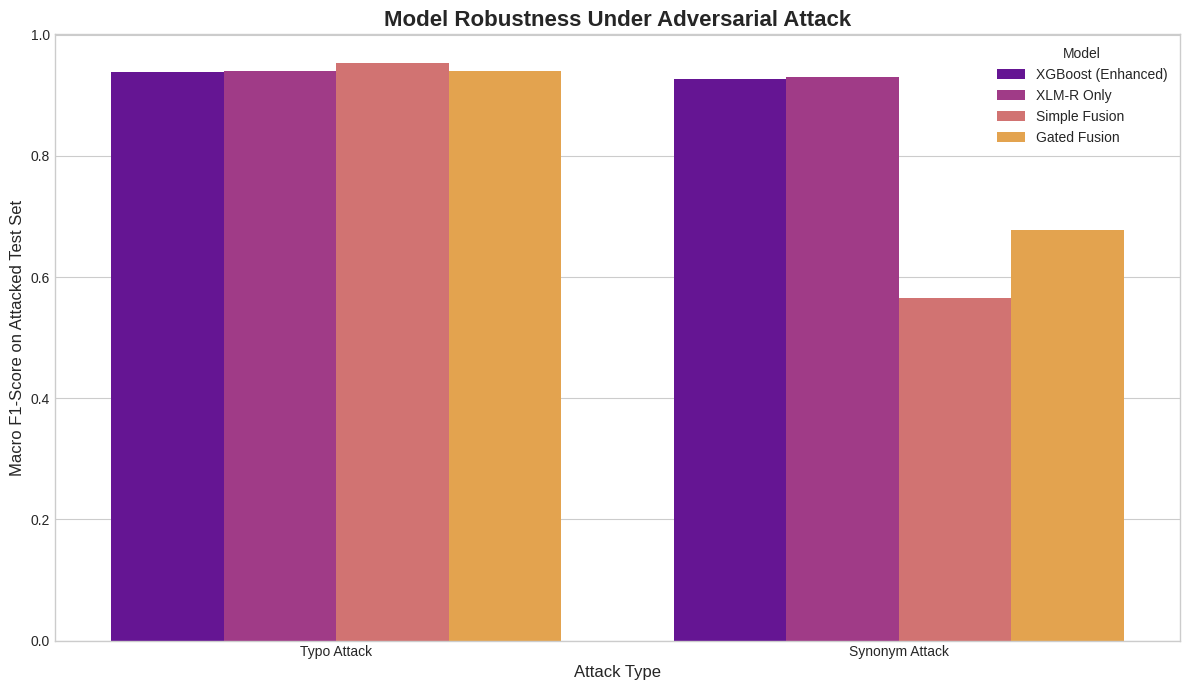

In [22]:
# ==============================================================================
# Comprehensive Adversarial Robustness Evaluation
# ==============================================================================
#
# Description:
# This script conducts the final, comprehensive experiment for the research paper.
# It evaluates the robustness of all key models against the two manually
# generated adversarial attacks (Typos and Synonyms). The models are:
#   1. XGBoost (Enhanced Features)
#   2. XLM-RoBERTa (Text Only)
#   3. XLM-R + Simple Fusion (Original 10 Features)
#   4. XLM-R + Gated Fusion (Enhanced Features)
#
# The script calculates the Macro F1-Score for each model on each attacked
# dataset and generates a final bar chart comparing their performance.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

# --- Step 1: Install Requirements ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import textstat
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# --- Step 2: Configuration ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Paths to Data
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv") # Needed to retrieve source metadata
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms_multilingual.csv")

    # Paths to Models and Artifacts
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlm_roberta_baseline_model.bin")
    SIMPLE_FUSION_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_plus_plus_model.bin")
    GATED_FUSION_MODEL_PATH = os.path.join(BASE_DIR, "x_frame_gated_model.bin")

    # Scalers and Encoders from different experiments
    SCALER_ORIGINAL_PATH = os.path.join(BASE_DIR, "x_frame_feature_scaler.joblib")
    SCALER_ENHANCED_PATH = os.path.join(BASE_DIR, "x_frame_gated_scaler.joblib")
    ENCODER_ENHANCED_PATH = os.path.join(BASE_DIR, "x_frame_gated_encoder.joblib")

    # Paths to Attacked Datasets
    ATTACKED_DIR = os.path.join(BASE_DIR, "attacked_datasets_manual")
    TYPO_ATTACK_PATH = os.path.join(ATTACKED_DIR, "test_attacked_typos.csv")
    SYNONYM_ATTACK_PATH = os.path.join(ATTACKED_DIR, "test_attacked_synonyms.csv")

    # Output Paths
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "adversarial_results_all_models.csv")
    RESULTS_PLOT_PATH = os.path.join(BASE_DIR, "adversarial_robustness_all_models.png")

    MODEL_NAME = 'xlm-roberta-base'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    MAX_LEN = 256

# --- Step 3: Feature Extractors and Model Architectures ---
class EnhancedFeatureExtractor:
    def __init__(self, terms_path):
        self.spacy_models = {lang: spacy.load(name) for lang, name in {"en": "en_core_web_sm", "fr": "fr_core_news_sm", "de": "de_core_news_sm", "es": "es_core_news_sm"}.items()}
        try:
            terms_df = pd.read_csv(terms_path)
            self.term_dict = {lang: set(terms_df[terms_df['lang'] == lang]['term'].tolist()) for lang in terms_df['lang'].unique()}
        except FileNotFoundError: self.term_dict = {}
        self.standards_terms = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
        self.safety_terms = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

    def extract(self, text, lang='en'):
        text = str(text)
        doc = self.spacy_models.get(lang, self.spacy_models['en'])(text)
        words = [token.text.lower() for token in doc]
        numbers = [float(num) for num in re.findall(r'\d+\.?\d*', text)]
        features = [
            len(text), len(words), len(list(doc.sents)),
            textstat.flesch_reading_ease(text) if lang == 'en' else np.nan,
            textstat.gunning_fog(text) if lang == 'en' else np.nan,
            sum(1 for w in words if w in self.term_dict.get(lang, set())) / len(words) if words else 0,
            sum(1 for char in text if char in '.,;:!?'),
            len(numbers),
            1 if any(term in text.lower() for term in self.standards_terms) else 0,
            1 if any(term in text.lower() for term in self.safety_terms) else 0,
            np.mean(numbers) if numbers else 0,
            sum(1 for n in numbers if n != int(n)) / len(numbers) if numbers else 0
        ]
        return np.array(features, dtype=np.float32)

class SimpleFusionModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(SimpleFusionModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        combined = torch.cat((outputs.pooler_output, engineered_features), dim=1)
        return self.classifier(combined)

class GatedFusionModel(nn.Module):
    def __init__(self, n_classes, n_engineered_features):
        super(GatedFusionModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(Config.MODEL_NAME)
        roberta_hidden_size = self.roberta.config.hidden_size
        self.gate = nn.Sequential(nn.Linear(roberta_hidden_size + n_engineered_features, n_engineered_features), nn.Sigmoid())
        self.classifier = nn.Linear(roberta_hidden_size + n_engineered_features, n_classes)
    def forward(self, input_ids, attention_mask, engineered_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = outputs.pooler_output
        gate_values = self.gate(torch.cat((text_embedding, engineered_features), dim=1))
        gated_engineered_features = gate_values * engineered_features
        final_fused_embedding = torch.cat((text_embedding, gated_engineered_features), dim=1)
        return self.classifier(final_fused_embedding)

# --- Step 4: Evaluation Function ---
def evaluate_transformer_model(model, data_loader, model_type='text_only'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}", leave=False):
            if model_type == 'text_only':
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE))
                logits = outputs.logits
            else: # Fused models
                outputs = model(input_ids=batch['input_ids'].to(Config.DEVICE), attention_mask=batch['attention_mask'].to(Config.DEVICE), engineered_features=batch['engineered_features'].to(Config.DEVICE))
                logits = outputs
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Step 5: Main Execution Block ---
if __name__ == '__main__':
    print(f"Using device: {Config.DEVICE}")

    # --- Prepare Models and Artifacts ---
    tokenizer = XLMRobertaTokenizer.from_pretrained(Config.MODEL_NAME)
    feature_extractor = EnhancedFeatureExtractor(Config.TERMS_PATH)
    scaler_original = joblib.load(Config.SCALER_ORIGINAL_PATH)
    scaler_enhanced = joblib.load(Config.SCALER_ENHANCED_PATH)
    encoder_enhanced = joblib.load(Config.ENCODER_ENHANCED_PATH)

    # Load Models
    xlm_r_model = XLMRobertaForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=2)
    xlm_r_model.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH), strict=False)
    xlm_r_model.to(Config.DEVICE)

    n_original_features = 10
    simple_fusion_model = SimpleFusionModel(n_classes=2, n_engineered_features=n_original_features)
    simple_fusion_model.load_state_dict(torch.load(Config.SIMPLE_FUSION_MODEL_PATH), strict=False)
    simple_fusion_model.to(Config.DEVICE)

    n_enhanced_features = 12 + len(encoder_enhanced.categories_[0])
    gated_fusion_model = GatedFusionModel(n_classes=2, n_engineered_features=n_enhanced_features)
    gated_fusion_model.load_state_dict(torch.load(Config.GATED_FUSION_MODEL_PATH), strict=False)
    gated_fusion_model.to(Config.DEVICE)

    # Train XGBoost Model
    print("Training XGBoost baseline model on enhanced features...")
    train_df = pd.read_csv(Config.TRAIN_PATH)
    train_num_raw = np.array([feature_extractor.extract(row['content'], row.get('lang', 'en')) for _, row in train_df.iterrows()])
    mean_flesch = np.nanmean(train_num_raw[:, 3]); mean_gunning = np.nanmean(train_num_raw[:, 4])
    train_num_df = pd.DataFrame(train_num_raw); train_num_df[3].fillna(mean_flesch, inplace=True); train_num_df[4].fillna(mean_gunning, inplace=True)
    train_num_scaled = scaler_enhanced.transform(train_num_df.values)
    train_src_encoded = encoder_enhanced.transform(train_df[['source']]).toarray()
    X_train_xgb = np.concatenate([train_num_scaled, train_src_encoded], axis=1)
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train_xgb, train_df['label'])

    # --- Evaluation Loop ---
    attack_files = {"Typo Attack": Config.TYPO_ATTACK_PATH, "Synonym Attack": Config.SYNONYM_ATTACK_PATH}
    results = []

    # Load original test data to retrieve metadata
    original_test_df = pd.read_csv(Config.TEST_PATH)

    for attack_name, attack_path in attack_files.items():
        print(f"\n--- Evaluating against {attack_name} ---")
        if not os.path.exists(attack_path):
            print(f"Attack file not found: {attack_path}. Skipping."); continue

        attack_df = pd.read_csv(attack_path)

        # --- FIX for missing 'source' column ---
        # Merge with original test data to add back the source and lang columns
        attack_df = pd.merge(
            attack_df,
            original_test_df[['content', 'source']].rename(columns={'content': 'original_content'}),
            on='original_content',
            how='left'
        )
        # --- END FIX ---

        y_true = attack_df['label']

        # Prepare all feature sets for the attacked data
        attack_features_raw = np.array([feature_extractor.extract(row['attacked_content'], row.get('lang', 'en')) for _, row in attack_df.iterrows()])
        attack_features_df = pd.DataFrame(attack_features_raw); attack_features_df[3].fillna(mean_flesch, inplace=True); attack_features_df[4].fillna(mean_gunning, inplace=True)

        attack_features_original_scaled = scaler_original.transform(attack_features_df.iloc[:, :10].values)
        attack_features_enhanced_scaled = scaler_enhanced.transform(attack_features_df.values)
        # FIX: Convert sparse matrix to dense array before concatenation
        attack_src_encoded = encoder_enhanced.transform(attack_df[['source']]).toarray()
        attack_features_xgb = np.concatenate([attack_features_enhanced_scaled, attack_src_encoded], axis=1)

        # --- Evaluate Models ---
        class AttackDataset(Dataset):
            def __init__(self, df, features=None): self.df, self.features = df, features
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                encoding = tokenizer.encode_plus(str(self.df.iloc[idx]['attacked_content']), add_special_tokens=True, max_length=Config.MAX_LEN, return_token_type_ids=False, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
                item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
                if self.features is not None: item['engineered_features'] = torch.tensor(self.features[idx], dtype=torch.float)
                return item

        # XGBoost
        xgb_preds = xgb_model.predict(attack_features_xgb)
        results.append({'Model': 'XGBoost (Enhanced)', 'Attack': attack_name, 'Macro F1-Score': f1_score(y_true, xgb_preds, average='macro')})

        # XLM-R Only
        xlm_r_loader = DataLoader(AttackDataset(attack_df), batch_size=Config.BATCH_SIZE)
        xlm_r_preds = evaluate_transformer_model(xlm_r_model, xlm_r_loader, 'text_only')
        results.append({'Model': 'XLM-R Only', 'Attack': attack_name, 'Macro F1-Score': f1_score(y_true, xlm_r_preds, average='macro')})

        # Simple Fusion
        simple_fusion_loader = DataLoader(AttackDataset(attack_df, attack_features_original_scaled), batch_size=Config.BATCH_SIZE)
        simple_fusion_preds = evaluate_transformer_model(simple_fusion_model, simple_fusion_loader, 'fused')
        results.append({'Model': 'Simple Fusion', 'Attack': attack_name, 'Macro F1-Score': f1_score(y_true, simple_fusion_preds, average='macro')})

        # Gated Fusion
        gated_fusion_loader = DataLoader(AttackDataset(attack_df, attack_features_xgb), batch_size=Config.BATCH_SIZE)
        gated_fusion_preds = evaluate_transformer_model(gated_fusion_model, gated_fusion_loader, 'fused')
        results.append({'Model': 'Gated Fusion', 'Attack': attack_name, 'Macro F1-Score': f1_score(y_true, gated_fusion_preds, average='macro')})

    # --- Final Results Visualization ---
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80 + "\nADVERSARIAL ROBUSTNESS FINAL RESULTS\n" + "="*80)
    print(results_df)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Attack', y='Macro F1-Score', hue='Model', data=results_df, palette='plasma')
    plt.title('Model Robustness Under Adversarial Attack', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=12)
    plt.ylabel('Macro F1-Score on Attacked Test Set', fontsize=12)
    plt.legend(title='Model', loc='best')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(Config.RESULTS_PLOT_PATH, dpi=300)
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")
    print(f"✅ Results plot saved to: {Config.RESULTS_PLOT_PATH}")


In [23]:
# ==============================================================================
# Final Data Integrity & Label Verification Script
# ==============================================================================
#
# Description:
# This script performs the definitive check on the data labeling of the entire
# Engineering Misinformation Corpus (EMC). It loads the train, validation, and
# test splits, combines them into a single master dataframe, and runs a
# source-label cross-tabulation.
#
# This is a critical step to verify that sources like 'faa' and 'nsit' were
# correctly labeled as "Real" (0) and that user-generated sources like 'reddit'
# were correctly labeled as "Misinformation" (1), resolving any discrepancies
# found in previous analyses.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

import pandas as pd
import os

# --- Configuration: Please verify these paths ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")

if __name__ == '__main__':
    print("--- Running Final Data Integrity & Label Verification ---")

    try:
        train_df = pd.read_csv(Config.TRAIN_PATH)
        val_df = pd.read_csv(Config.VAL_PATH)
        test_df = pd.read_csv(Config.TEST_PATH)
        print("All dataset splits loaded successfully.")
    except FileNotFoundError as e:
        print(f"ERROR: Could not find a dataset file. Please check your paths. Details: {e}")
        exit()

    # --- Combine all splits into a single master dataframe ---
    full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    print(f"Total samples in the combined corpus: {len(full_df)}")

    # --- Perform the Definitive Source vs. Label Analysis ---
    if 'source' in full_df.columns and 'label' in full_df.columns:
        print("\n" + "="*80)
        print("DEFINITIVE SOURCE VS. LABEL BREAKDOWN (ENTIRE CORPUS)")
        print("="*80)

        # Use crosstab to see the ground-truth relationship between source and label
        # We map the label to a string for clarity in the output
        analysis_table = pd.crosstab(
            full_df['source'],
            full_df['label'].map({0: 'Real (0)', 1: 'Misinformation (1)'})
        )

        print(analysis_table)

        print("\n" + "="*80)
        print("Please review the table above to confirm the ground-truth labeling.")

    else:
        print("\n[ERROR] The 'source' or 'label' column is missing from the dataset.")


    print("\n\n✅ Verification script complete.")


--- Running Final Data Integrity & Label Verification ---
All dataset splits loaded successfully.
Total samples in the combined corpus: 19350

DEFINITIVE SOURCE VS. LABEL BREAKDOWN (ENTIRE CORPUS)
label                      Misinformation (1)  Real (0)
source                                                 
ai                                       4610      4350
eng_tips                                    0       160
engineering_stackexchange                 990       997
faa                                         0      2017
nsit                                        0      1878
reddit                                     20      4328

Please review the table above to confirm the ground-truth labeling.


✅ Verification script complete.


In [1]:
# ==============================================================================
# Corrected EMC Dataset Statistics Script
# ==============================================================================
#
# Description:
# This script provides the definitive and final statistical breakdown of the
# CORRECTED Engineering Misinformation Corpus (EMC). It loads the corrected
# train, validation, and test splits, analyzes each one individually, and then
# combines them to provide an overall summary of the entire corpus.
#
# The output of this script should be used to populate the final tables in the
# research paper's appendix to ensure perfect accuracy and reproducibility.
#
# Author: Gemini
# Date: July 25, 2025
#
# ==============================================================================

import pandas as pd
import os

# --- Configuration: Please verify these paths ---
class Config:
    BASE_DIR = "/content/drive/MyDrive/RINSGE"
    # If in Colab:
    # BASE_DIR = "/content/drive/MyDrive/RINSGE"

    # Paths to the CORRECTED data files
    TRAIN_PATH = os.path.join(BASE_DIR, "emc_train_corrected.csv")
    VAL_PATH = os.path.join(BASE_DIR, "emc_val_corrected.csv")
    TEST_PATH = os.path.join(BASE_DIR, "emc_test_corrected.csv")

def analyze_and_print(df, title):
    """Helper function to calculate and print stats for a given dataframe."""
    print("\n" + "="*80)
    print(f"STATISTICS FOR: {title}")
    print("="*80)

    # --- Shape ---
    print(f"\nTotal Samples: {len(df)}")

    # --- Label Distribution ---
    label_counts = df['label'].value_counts()
    print("\nLabel Distribution:")
    print(f"  Real (0): {label_counts.get(0, 0)}")
    print(f"  Misinformation (1): {label_counts.get(1, 0)}")
    print(f"  % Misinformation: {label_counts.get(1, 0) / len(df) * 100:.2f}%")

    # --- Language Distribution ---
    if 'lang' in df.columns:
        print("\nLanguage Distribution:")
        print(df['lang'].value_counts())

    # --- Source Distribution ---
    if 'source' in df.columns:
        print("\nSource Distribution:")
        print(df['source'].value_counts())

        # Detailed Source x Label breakdown
        print("\nSource vs. Label Breakdown:")
        print(pd.crosstab(df['source'], df['label'].map({0: 'Real (0)', 1: 'Misinformation (1)'})))

if __name__ == '__main__':
    try:
        train_df = pd.read_csv(Config.TRAIN_PATH)
        val_df = pd.read_csv(Config.VAL_PATH)
        test_df = pd.read_csv(Config.TEST_PATH)
    except FileNotFoundError as e:
        print(f"ERROR: Could not find a dataset file. Please check your paths. Details: {e}")
        exit()

    # --- Analyze Individual Splits ---
    analyze_and_print(train_df, "Training Set (Corrected)")
    analyze_and_print(val_df, "Validation Set (Corrected)")
    analyze_and_print(test_df, "Test Set (Corrected)")

    # --- Combine and Analyze Full Dataset ---
    full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    analyze_and_print(full_df, "Full EMC Corpus (Corrected & Combined)")

    print("\n\n✅ Analysis complete. Use these numbers for your appendix.")



STATISTICS FOR: Training Set (Corrected)

Total Samples: 11610

Label Distribution:
  Real (0): 8238
  Misinformation (1): 3372
  % Misinformation: 29.04%

Language Distribution:
lang
en    9810
fr     600
de     600
es     600
Name: count, dtype: int64

Source Distribution:
source
ai                           5376
reddit                       2609
faa                          1210
engineering_stackexchange    1192
nsit                         1127
eng_tips                       96
Name: count, dtype: int64

Source vs. Label Breakdown:
label                      Misinformation (1)  Real (0)
source                                                 
ai                                       2766      2610
eng_tips                                    0        96
engineering_stackexchange                 594       598
faa                                         0      1210
nsit                                        0      1127
reddit                                     12      2597

STATISTI